# Statistiques descriptives

Ce NoteBook rassemble l'ensemble des statistiques descriptives sur les données de validations dans les stations de RER, sur les données socio démographiques de l'Insee associées au carreau de 1 kilomètre dans lequel se situent les stations de *RER*. 

In [1]:
!pip install plotly

In [2]:
from IPython.utils import io
from io import BytesIO  

with io.capture_output() as captured: #on évite d'afficher les sorties lors de l'importation
    !pip install pandas fiona shapely pyproj rtree
    !pip install geopandas
    !pip install topojson
    !pip install contextily
    !pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
    !pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
    !pip install chart_studio


In [3]:
import pandas as pd
import geopandas as gpd
from _jointure_validations_stations import df_jointure_validations_stations
import matplotlib.pyplot as plt
from _pre_proces_stations import df_stations
import plotly.express as px
import seaborn as sns
import contextily as ctx
import matplotlib.cm as cm

In [4]:
data=df_jointure_validations_stations()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [5]:
data


JOUR    lda CATEGORIE_TITRE  NB_VALD  Mois  Année  \
0      2023-01-01  66858      NON DEFINI       55     1   2023   
1      2023-01-01  66858       AMETHYSTE       32     1   2023   
2      2023-01-01  66858             FGT       93     1   2023   
3      2023-01-01  66858       IMAGINE R      316     1   2023   
4      2023-01-01  66858          NAVIGO      458     1   2023   
...           ...    ...             ...      ...   ...    ...   
204312 2023-06-30  67625       IMAGINE R      320     6   2023   
204313 2023-06-30  67625          NAVIGO      893     6   2023   
204314 2023-06-30  67625     NAVIGO JOUR        9     6   2023   
204315 2023-06-30  67625      NON DEFINI        7     6   2023   
204316 2023-06-30  67625             TST      125     6   2023   

                         arret  lignes  bus_jour  noctilien  ... ind_40_54  \
0       Cergy-Saint-Christophe       2        16          2  ...    1697.0   
1       Cergy-Saint-Christophe       2        16          2  ...    1697.0   
2       Cergy-Saint-Christophe       2        16          2  ...    1697.0   
3       Cergy-Saint-Christophe       2        16          2  ...    1697.0   
4       Cergy-Saint-Christophe       2        16          2  ...    1697.0   
...                        ...     ...       ...        ...  ...       ...   
204312                 Tournan       2        17          1  ...     654.0   
204313                 Tournan       2        17          1  ...     654.0   
204314                 Tournan       2        17          1  ...     654.0   
204315                 Tournan       2        17          1  ...     654.0   
204316                 Tournan       2        17          1  ...     654.0   

       ind_55_64 ind_65_79  ind_80p ind_inc pre_IDF  select expt     res_com  
0          902.9     619.1     92.0    46.0     1.0     1.0  1.0 NaN   RER A  
1          902.9     619.1     92.0    46.0     1.0     1.0  1.0 NaN   RER A  
2          902.9     619.1     92.0    46.0     1.0     1.0  1.0 NaN   RER A  
3          902.9     619.1     92.0    46.0     1.0     1.0  1.0 NaN   RER A  
4          902.9     619.1     92.0    46.0     1.0     1.0  1.0 NaN   RER A  
...          ...       ...      ...     ...     ...     ...  ...  ..     ...  
204312     321.1     314.0     99.0     1.0     1.0     1.0  1.0 NaN   RER E  
204313     321.1     314.0     99.0     1.0     1.0     1.0  1.0 NaN   RER E  
204314     321.1     314.0     99.0     1.0     1.0     1.0  1.0 NaN   RER E  
204315     321.1     314.0     99.0     1.0     1.0     1.0  1.0 NaN   RER E  
204316     321.1     314.0     99.0     1.0     1.0     1.0  1.0 NaN   RER E  

[204317 rows x 74 columns]

## Sur la fréquentation des stations de RER
Les données de validations sont obtenues à partir de tous les supports de télé-billetiques : cela signifie que les tickets en carton ne sont pas pris en compte, seuls les pass Navigo sont comptabilisés dans ces données. 

Quelques précisions sur les données de validations afin de bien comprendre la manière dont on pourrait utiliser cette base.

Les données de validations ne comptabilisent pas :
- les tickets magnétiques (par exemple, les ticket T+, Forfait Mobilis, Forfait Paris Visite, etc.)
- les usagers qui ne valident pas à la montée dans un bus ou tram, ou en entrant dans une gare (par exemple si le quai est
accessible sans passer par une barrière de contrôle, ou si les barrières de contrôle sont indisponibles en raison de travaux, etc. )
- les fraudeurs

… et donnent donc une vision incomplète du trafic sur le réseau de transport.

La base de données ci-dessus est tirée d'une base de données elle-même composée :
- du **réseau ferré** (RER, métro, transilien), qui est caractérisé par des **arrêts** 
- du réseau dit de **"lignes administratives"** (bus, tram), aussi appelé **réseau de surface**, qui est caractérisé par des **lignes**

Cela génère une différence dans le type de validation :
- les validations du **réseau ferré** sont rattachées à une **station**
- les validations du **réseau de surface** sont rattachées à une **ligne** (car les valideurs sont embarqués dans les véhicules et donc mobiles).

**Qu'est-ce qu'une ligne ?**
Dans les données de validation, la notion de ligne regroupe un ensemble d’arrêts prédéfinis par l’offre de transport. Elle est identifiée par un nom de ligne et un identifiant de ligne.

**Qu'est-ce qu'un arrêt ?**
Dans les données de validation, un arrêt est le lieu où le voyageur valide son titre de transport sur le réseau ferré (i.e. dans une station de métro ou une gare). Il est identifié par un nom d’arrêt et un identifiant de l’arrêt.

**Conclusion** : dans notre base de donnée à nous, nous n'avons **que les validations du réseau ferré**, et donc **par arrêt**. 


Voici quelques précisions sur les différentes catégories de titre : 
- **IMAGINE R** : regroupe les forfaits annuels Imagine R Scolaire et Imagine R Etudiant, forfaits réservés aux élèves, apprentis et étudiants qui permet de voyager à volonté toute l’année et dans toute l Ile-de-France.
- **NAVIGO** : regroupe les forfaits Navigo Annuel, Navigo Mois et Navigo Semaine.
- **AMETHYSTE** : comptabilise les forfaits Améthyste : forfait réservé aux personnes âgées ou handicapées sous conditions de ressources ou de statut, et résidant en Île-de-France. Ce forfait
annuel permet à son bénéficiaire de se déplacer de manière illimitée sur tous les modes de transport à l intérieur des zones de validité.
- **TST** : regroupe les forfaits hebdomadaires et mensuels à tarif réduit, accordé aux bénéficiaires
de la Réduction Solidarité Transport, pour voyager à l’intérieur des zones choisies sur tous les
modes de transport en Île-de-France.
- **FGT** : comptabilise les Forfaits Navigo Gratuité Transport, forfait qui permet à certain bénéficiaire d’aides sociales de voyager gratuitement dans toute l’Île-de-France.
- **AUTRE TITRE** : comptabilise les forfaits spéciaux.
- **NON DEFINI** : comptabilise les validations dont le type de titre n’est pas défini (anomalies).

Ensuite, il est important de noter qu'il s'agit de validations uniquement à l'entrée des stations. Il n'est donc pas question ici d'analyser les déplacements, de plutot de voir la fréquentation en "entrée" des stations. Pour restreindre notre analyse avec le temps que l'on a pour réaliser ce projet nous avons décider de nous restreindre uniquement aux stations de *RER*.

### Fréquentation globale du réseau de RER par jour
On commence par aggréger les données par jour pour avoir un appercu de la fréquentation globale du *RER* en Île de France.

In [6]:
freq=data.loc[:,['JOUR', 'nom_long', 'CATEGORIE_TITRE', 'NB_VALD']]
freq_S1 = freq.groupby(['JOUR'])['NB_VALD'].sum().reset_index()
freq_S1.head()

JOUR  NB_VALD
0 2023-01-01   246904
1 2023-01-02   826620
2 2023-01-03  1140870
3 2023-01-04  1169329
4 2023-01-05  1236762

In [7]:
freq_S1.loc[:,['NB_VALD']].describe()

NB_VALD
count  1.810000e+02
mean   9.625740e+05
std    2.999781e+05
min    2.469040e+05
25%    6.697630e+05
50%    1.110501e+06
75%    1.210960e+06
max    1.348518e+06

La fréquentation de l'ensemble du *RER* au premier semestre 2023 est très différente selon les jours : le jour de fréquentation le plus forte a près de 6 fois plus de validations que le jour avec la fréquentation la plus faible. Par jour, il y a en moyenne 1,8 millions de validation, tandis que plus la moitié des jours ont plus de 2 millions de validation. Cette écart important entre la moyenne et la médiane pourrait être dû aux fortes variations qu'il existe entre la semaine et les weekends sur la fréquentation des *RER*.

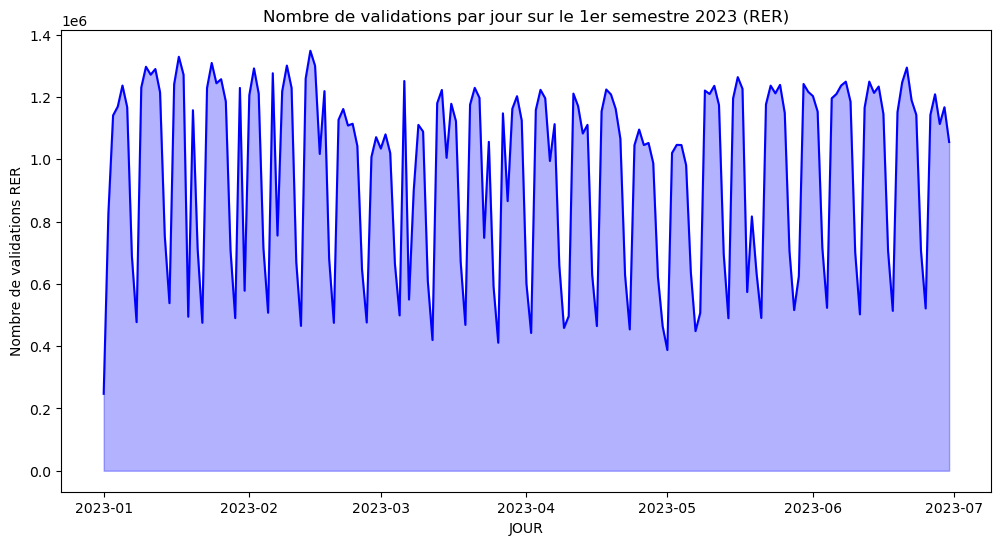

In [8]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='JOUR', y='NB_VALD', data=freq_S1, color = "blue")
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="blue", alpha=0.3)
ax.set_ylabel('Nombre de validations RER')

plt.title('Nombre de validations par jour sur le 1er semestre 2023 (RER)')
plt.show()

La variation en fonction du "type" de jour est très importante comme le fait apparaître ce graphique : l'écart entre la fréquentation en semaine et le weekend est du simple au double/triple.

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

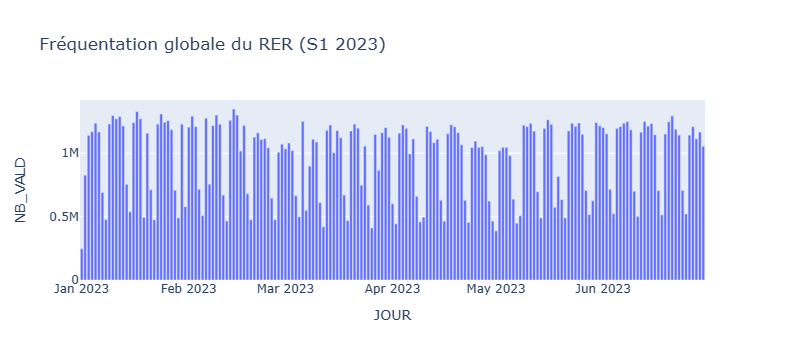

In [9]:
px.bar(freq_S1, x='JOUR', y='NB_VALD',
             title='Fréquentation globale du RER (S1 2023)')

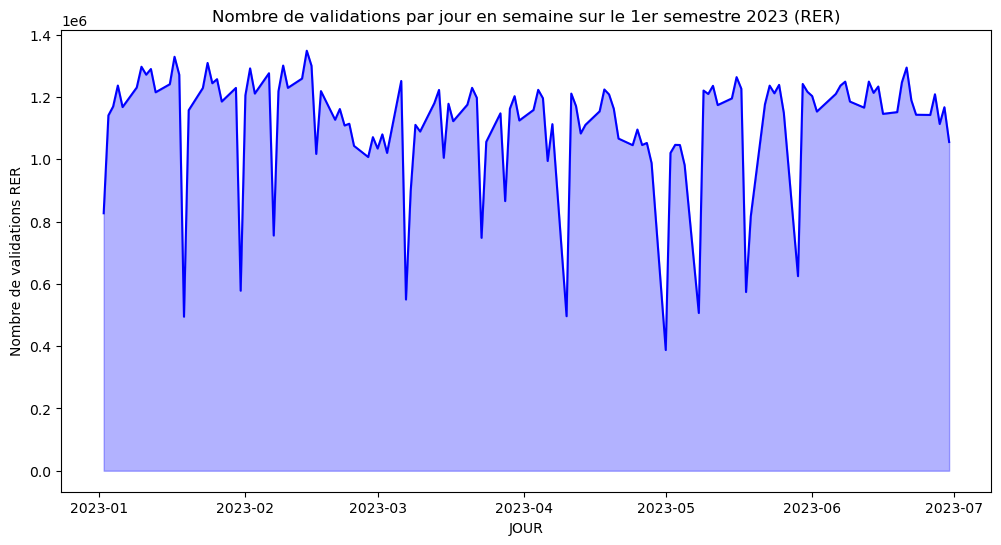

In [10]:
freq_S1['semaine'] = freq_S1['JOUR'].apply(lambda x: 1 if x.weekday() < 5 else 0)

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='JOUR', y='NB_VALD', data=freq_S1[freq_S1['semaine']==1], color = "blue")
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="blue", alpha=0.3)
ax.set_ylabel('Nombre de validations RER')

plt.title('Nombre de validations par jour en semaine sur le 1er semestre 2023 (RER)')
plt.show()

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

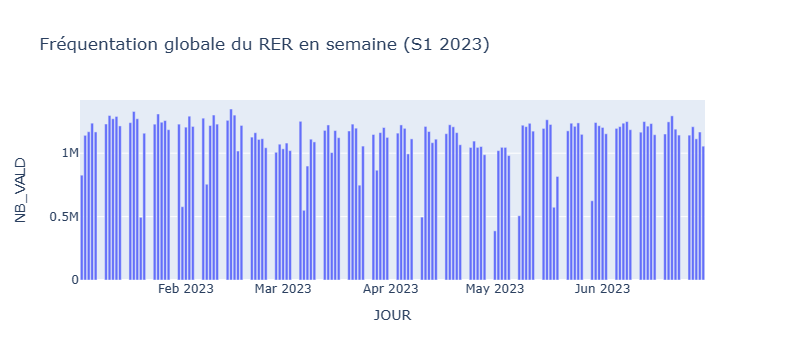

In [11]:
px.bar(freq_S1[freq_S1['semaine']==1], x='JOUR', y='NB_VALD',
             title='Fréquentation globale du RER en semaine (S1 2023)')

In [12]:
freq_S1['NB_VALD'].var()

89986876505.11417

In [13]:
freq_S1[freq_S1['semaine']==1].loc[:,['NB_VALD']].var()

NB_VALD    3.520759e+10
dtype: float64

Lorsque l'on ne regarde que la fréquentation en semaine il reste tout de même beaucoup de variations, même si elle est drastiquement diminuée (variance presque trois fois plus élevée sur l'ensemble de la semaine).

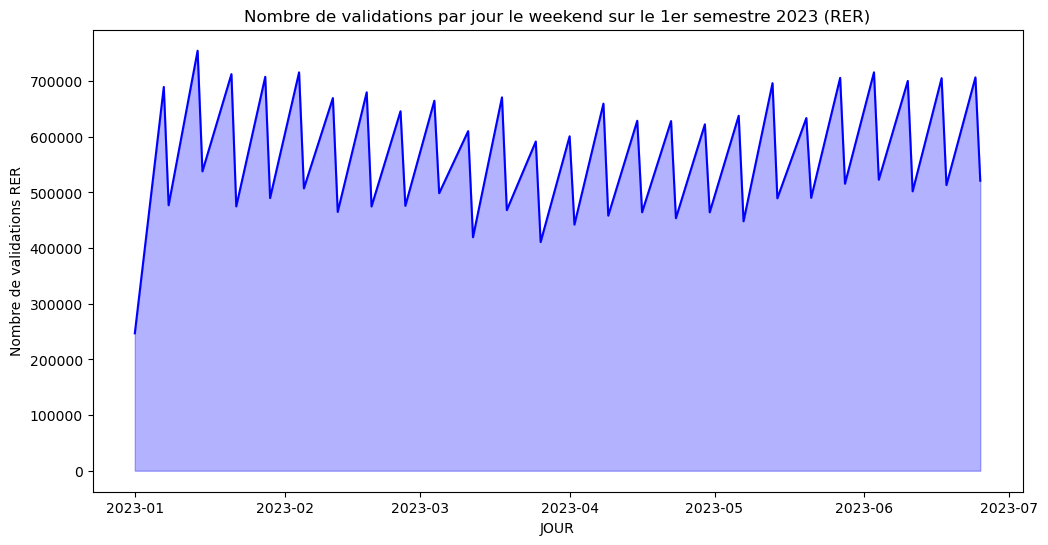

In [14]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='JOUR', y='NB_VALD', data=freq_S1[freq_S1['semaine']==0], color = "blue")
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="blue", alpha=0.3)
ax.set_ylabel('Nombre de validations RER')

plt.title('Nombre de validations par jour le weekend sur le 1er semestre 2023 (RER)')
plt.show()

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

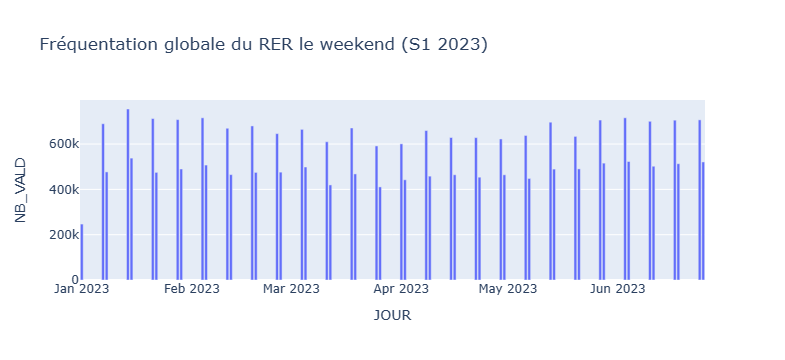

In [15]:
px.bar(freq_S1[freq_S1['semaine']==0], x='JOUR', y='NB_VALD',
             title='Fréquentation globale du RER le weekend (S1 2023)')

Le nombre de validations est beaucoup plus importante le samedi que le dimanche, mais leur part semble beaucoup plus stable au cours du semestre que pour les jours de semaine, traduisant une plus grande réguarité.

On se propose de regarder la fréquentation par ligne et par mois.

In [16]:
freq_ligne_mois=data.groupby(['Mois', 'res_com'])['NB_VALD'].sum().reset_index()
couleurs_res_com = {
    'RER A': 'red', 'RER B': 'blue', 'RER C': 'yellow',
    'RER D': 'green', 'RER E': 'pink'}
mois_correspondance = {
    1: 'Janvier',
    2: 'Février',
    3: 'Mars',
    4: 'Avril',
    5: 'Mai',
    6: 'Juin'
}
freq_ligne_mois['Nom_Mois'] = freq_ligne_mois['Mois'].map(mois_correspondance)
freq_ligne_mois

Mois              res_com  NB_VALD Nom_Mois
0      1                RER A  9216333  Janvier
1      1         RER A, RER E   638706  Janvier
2      1                RER B  4414008  Janvier
3      1                RER C  5056100  Janvier
4      1                RER D  2965751  Janvier
5      1         RER D, RER A  3143261  Janvier
6      1         RER D, RER C   629241  Janvier
7      1                RER E  1929522  Janvier
8      1  RER E, RER B, RER D  2469976  Janvier
9      2                RER A  8542748  Février
10     2         RER A, RER E   574950  Février
11     2                RER B  4004888  Février
12     2                RER C  4567092  Février
13     2                RER D  2703133  Février
14     2         RER D, RER A  2925188  Février
15     2         RER D, RER C   589611  Février
16     2                RER E  1696391  Février
17     2  RER E, RER B, RER D  2295053  Février
18     3                RER A  9140578     Mars
19     3         RER A, RER E   579796     Mars
20     3                RER B  4237531     Mars
21     3                RER C  4734994     Mars
22     3                RER D  2678638     Mars
23     3         RER D, RER A  3012073     Mars
24     3         RER D, RER C   645358     Mars
25     3                RER E  1681093     Mars
26     3  RER E, RER B, RER D  2275475     Mars
27     4                RER A  8407152    Avril
28     4         RER A, RER E   570920    Avril
29     4                RER B  4069290    Avril
30     4                RER C  4530789    Avril
31     4                RER D  2688509    Avril
32     4         RER D, RER A  2890492    Avril
33     4         RER D, RER C   610170    Avril
34     4                RER E  1643676    Avril
35     4  RER E, RER B, RER D  1809904    Avril
36     5                RER A  8700498      Mai
37     5         RER A, RER E   580506      Mai
38     5                RER B  4236348      Mai
39     5                RER C  4683217      Mai
40     5                RER D  2885570      Mai
41     5         RER D, RER A  3131859      Mai
42     5         RER D, RER C   698749      Mai
43     5                RER E  1695131      Mai
44     5  RER E, RER B, RER D  2005071      Mai
45     6                RER A  9462346     Juin
46     6         RER A, RER E   630620     Juin
47     6                RER B  4435594     Juin
48     6                RER C  5424042     Juin
49     6                RER D  3094496     Juin
50     6         RER D, RER A  3464372     Juin
51     6         RER D, RER C   655669     Juin
52     6                RER E  1842076     Juin
53     6  RER E, RER B, RER D  2031331     Juin

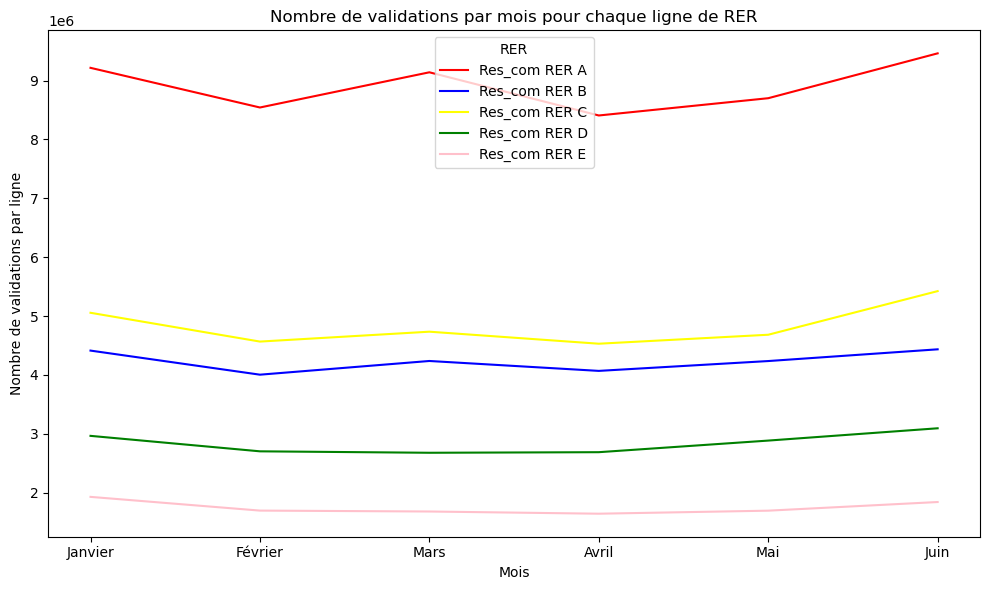

In [17]:
modalites = ['RER A', 'RER B', 'RER C', 'RER D', 'RER E']

# Créez un graphique avec une ligne distincte pour chaque modalité
fig, ax = plt.subplots(figsize=(10, 6))

for res_com in modalites:
    subset = freq_ligne_mois[freq_ligne_mois['res_com'] == res_com]
    couleur = couleurs_res_com.get(res_com, 'blue')  # Utilisez la couleur du dictionnaire ou 'blue' par défaut
    ax.plot(subset['Nom_Mois'], subset['NB_VALD'], label=f'Res_com {res_com}', color=couleur)

ax.set_xlabel('Mois')
ax.set_ylabel('Nombre de validations par ligne')
ax.set_title('Nombre de validations par mois pour chaque ligne de RER')
ax.legend(title='RER')

plt.tight_layout()

# Affichez le graphique
plt.show()

Il faut noter que les validations des stations en correspondance ne sont pas prises en compte dans ce graphique pour bien avoir les validations "propres" à chaque ligne (pour une station en correspondance il nous est impossible d'identifier à quelle ligne sont affectées les validations).

Sans surpise, le *RER A*, ligne de train la plus fréquentée d'Europe, a beaucoup plus de validation que les autres. On note qu'il existe des variations mensuelles : en février, on peut penser que les vacances d'hiver sont à l'origine de moins de validation sur le *RER A* (qui canalise beaucoup d'emplois. On peut également imaginer que la hausse des validations en juin est liée à une plus forte affluence touristique, ou simplement a une augmentation des déplacements avec l'augmentation de la durée des jours.

Maintenant que nous avons un apercu de la fréquentation globale du *RER* nous pouvons oberserver les différences qu'il existe entre les 5 lignes de *RER*.

### Fréquentation globale par station et par jour
Dans un second temps on s'interresse aux données de fréquentation que l'on aggrège par jour et par station, sur tous les jours du premier semestre 2023 et sur les stations de *RER*.

In [18]:
data.loc[:,['NB_VALD']].describe()

NB_VALD
count  204317.000000
mean      852.723391
std      2868.070470
min         5.000000
25%        23.000000
50%       125.000000
75%       529.000000
max     86233.000000

Il y a, en moyenne, 1005 validations par jour et par support dans les stations du *RER*, cependant cette moyenne cache de très gros écart. Il y a des stations qui sont extrèmement peu fréquentée : la documentation d'ÎDFM indique que lorsque le nombre de validations est inférieur à 5 mais strictement positif, la donnée est tronquée à 5 pour respecter les exigences de la CNIL.

#### Stations de RER très peu fréquentées

Une information statistique de ce tableau est également très interessante : le Q3 est inférieur à la moyenne : cela signifie que la fréquentation de certaines stations est si grande qu'elle "gonfle" la moyenne. Ces stations sont donc peu nombreuses au vue du nombre de stations totales du *RER* mais pourtant ce sont elles qui canalisent le plus de validation.

Pour identifier les stations avec les plus faibles validations on aggrégèe les données par jour (et donc on enlève les catégories). Il faut bien prendre en compte que le nombre de validations minimales gardé est de 5, et donc que, en aggrégeant par catégorie de pass Navigo on aura mécaniquement plus de validations (l'approximation sera gonflée). Si il n'y a aucune validation dans la journée pour un titre specifique la colonne est soit à 0 soit inexistante.

On considère qu'une station de *RER* est très faiblement fréquentée lorsqu'elle a moins de 100 validations par jour (tous supports confondus). Cela correspond à un peu plus de 5% des enregistrements de la table.

In [19]:
freq_stations = freq.groupby(['JOUR', 'nom_long'])['NB_VALD'].sum().reset_index()
freq_stations.head()

JOUR       nom_long  NB_VALD
0 2023-01-01          Ablon      336
1 2023-01-01  Achères-Ville      872
2 2023-01-01         Antony     2237
3 2023-01-01        Arpajon      229
4 2023-01-01     Athis-Mons      278

In [20]:
freq_stations['NB_VALD'].quantile(0.05)

55.0

In [21]:
faible_freq=freq_stations[freq_stations['NB_VALD'] <= 100]
faible_freq

JOUR             nom_long  NB_VALD
8     2023-01-01          Ballancourt       74
9     2023-01-01          Boigneville       17
10    2023-01-01      Boissise-le-Roi       31
16    2023-01-01             Boutigny       23
27    2023-01-01           Chamarande       41
...          ...                  ...      ...
26518 2023-06-30    Le Plessis-Chenet       94
26536 2023-06-30  Nanterre-Préfecture       94
26564 2023-06-30        Saint-Fargeau       20
26577 2023-06-30             Sermaise       10
26593 2023-06-30               Vosves       42

[1856 rows x 3 columns]

**commenter**

In [22]:
faible_freq_stations=faible_freq.loc[:,['nom_long']]
liste_faible_freq_stations= faible_freq_stations['nom_long'].value_counts()
liste_faible_freq_stations

nom_long
Boigneville             173
Vosves                  173
Le Plessis-Chenet       166
Le Coudray-Montceaux    162
Sermaise                157
                       ... 
Javel                     1
Avenue Foch               1
Auber                     1
Parc des Expositions      1
Nanterre-Préfecture       1
Name: count, Length: 77, dtype: int64

Sur l'ensemble du premier semestre 2023, plus d'une centaine de stations avaient moins de 100 validations pendant au moins une journée.

Sachant qu'il y avait 181 jours au premier semestre 2023, certaines stations sortent du lot de part leur faible fréquentation : Acères-Grand-Cormier n'a compté plus de 100 validations que 7 jours entre le 1er janvier et le 31 juin 2023.

Afin de poursuivre l'analyse nous regardons sur quelles lignes sont situées les stations les moins fréquentées. On propose d'abord une représentation graphique par ligne, puis ensuite une représentation graphique toutes lignes confondues.

In [23]:
stations=df_stations()

In [24]:
df=liste_faible_freq_stations.reset_index()
df.columns=['Station de RER', 'Nb de jours avec moins de 50 validations']
liste_faible_freq_stations=df.merge(stations, left_on="Station de RER", right_on="nom_long")

In [25]:
couleurs_res_com = {
    'RER A': 'red', 'RER B': 'blue', 'RER C': 'yellow',
    'RER D': 'green', 'RER E': 'pink'}

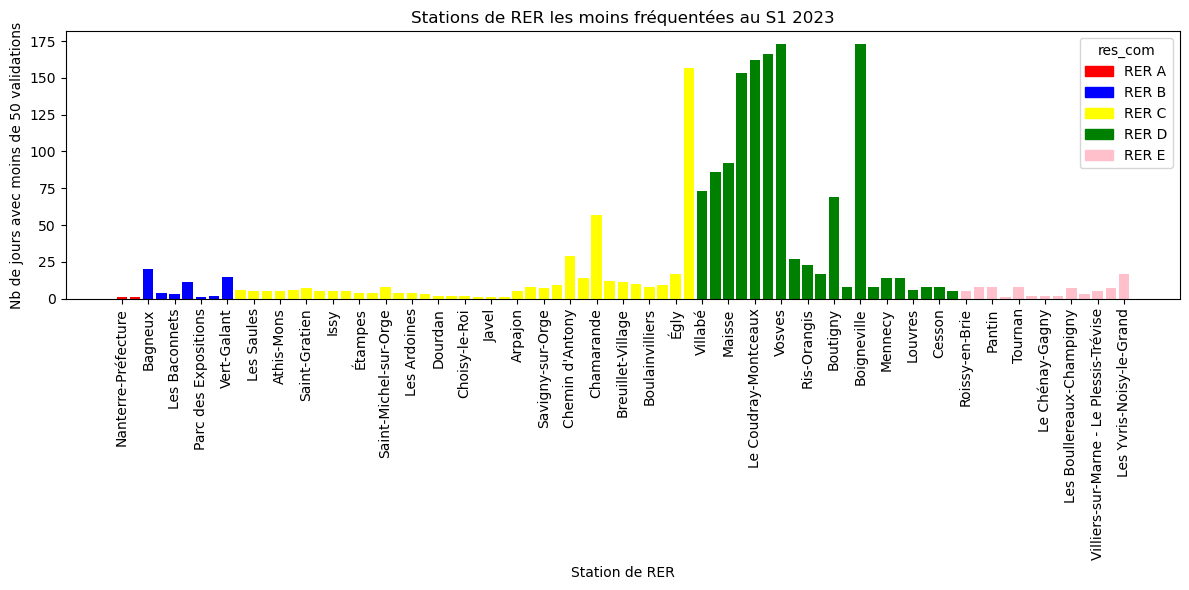

In [26]:
liste_faible_freq_stations2 = liste_faible_freq_stations.sort_values(by='res_com')

# Créez un graphique à barres avec Matplotlib en utilisant la couleur dépendante de res_com
plt.figure(figsize=(12, 6))
x = range(len(liste_faible_freq_stations2))  # Créez une séquence pour l'axe des abscisses
plt.bar(x, liste_faible_freq_stations2['Nb de jours avec moins de 50 validations'],
        color=[couleurs_res_com[res] for res in liste_faible_freq_stations2['res_com']])

# Ajustez les étiquettes de l'axe des abscisses pour n'afficher qu'une station sur trois
n = 2
plt.xticks(x[::n], liste_faible_freq_stations2['Station de RER'][::n], rotation=90)

plt.title('Stations de RER les moins fréquentées au S1 2023')
plt.xlabel('Station de RER')
plt.ylabel('Nb de jours avec moins de 50 validations')

# Créez une légende pour les catégories de res_com
handles = [plt.Rectangle((0, 0), 1, 1, color=couleurs_res_com[res]) for res in couleurs_res_com]
labels = couleurs_res_com.keys()
plt.legend(handles, labels, title='res_com')

# Affichez le graphique
plt.tight_layout()
plt.show()

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

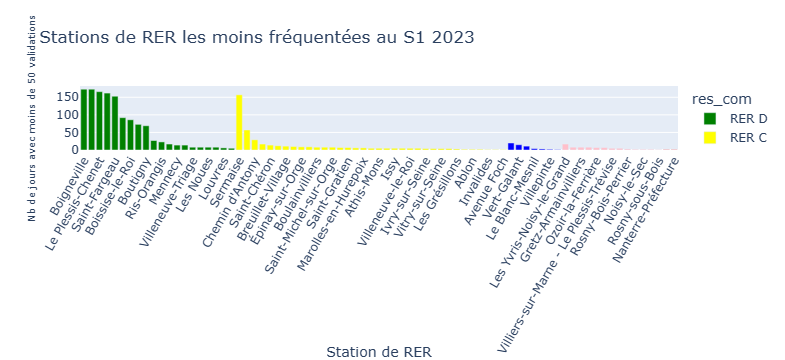

In [27]:
fig = px.bar(liste_faible_freq_stations, x='Station de RER', y='Nb de jours avec moins de 50 validations', color='res_com',
             title='Stations de RER les moins fréquentées au S1 2023',
            color_discrete_map=couleurs_res_com)

# Personnaliser le graphique
fig.update_layout(xaxis_tickangle=-60)  # Incliner les étiquettes de l'axe des abscisses
#fig.update_traces(marker_color='skyblue')  # La couleur par défaut des barres, peut être écrasée par 'color'
fig.update_yaxes(title_font=dict(size=10))  # Réduire la taille de la police pour l'axe des ordonnées

# Afficher le graphique
fig.show()

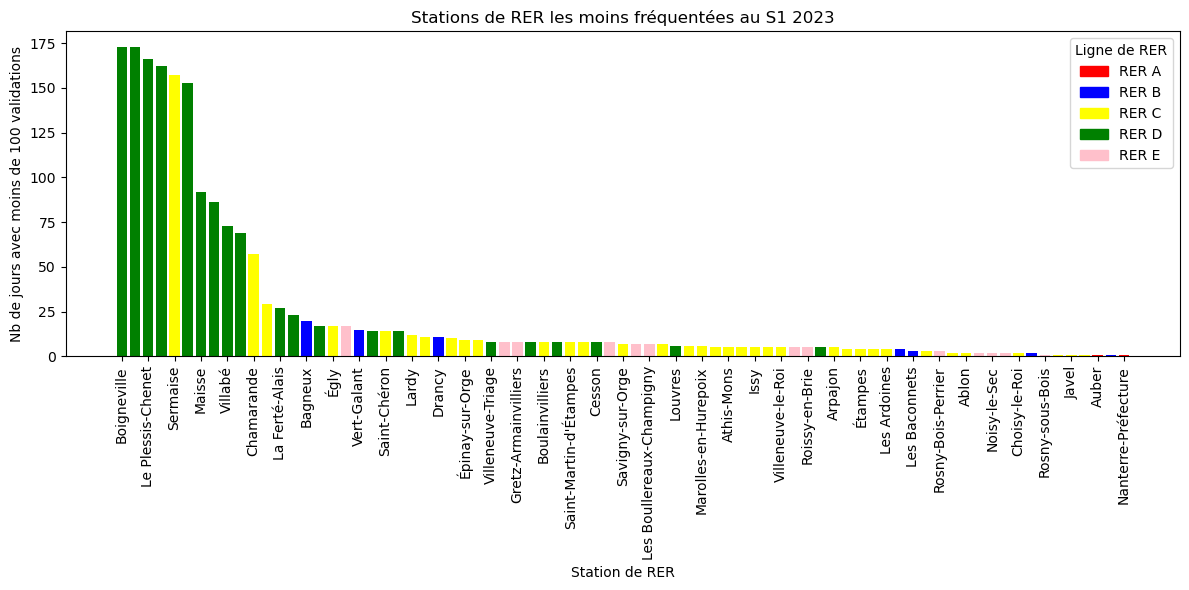

In [28]:
plt.figure(figsize=(12, 6))
x = liste_faible_freq_stations.index  # Utilisez l'indice du DataFrame comme abscisses
plt.bar(x, liste_faible_freq_stations['Nb de jours avec moins de 50 validations'],
        color=[couleurs_res_com[res] for res in liste_faible_freq_stations['res_com']])

# Ajustez les étiquettes de l'axe des abscisses pour n'afficher qu'une station sur trois
n = 2
plt.xticks(x[::n], liste_faible_freq_stations['Station de RER'][::n], rotation=90)

plt.title('Stations de RER les moins fréquentées au S1 2023')
plt.xlabel('Station de RER')
plt.ylabel('Nb de jours avec moins de 100 validations')

# Créez une légende pour les catégories de res_com
handles = [plt.Rectangle((0, 0), 1, 1, color=couleurs_res_com[res]) for res in couleurs_res_com]
labels = couleurs_res_com.keys()
plt.legend(handles, labels, title='Ligne de RER')

# Affichez le graphique
plt.tight_layout()
plt.show()

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

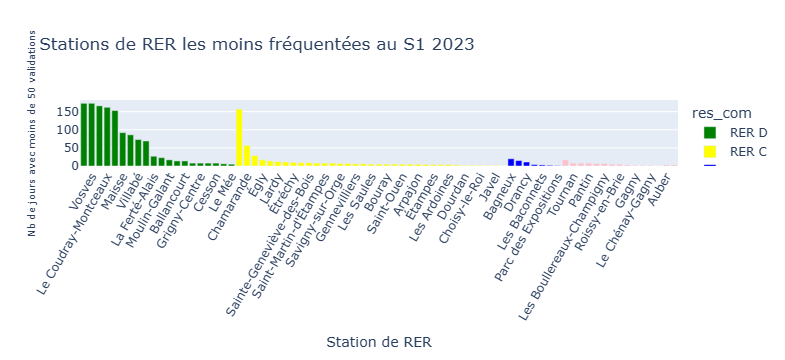

In [29]:
# Créer un graphique en barres interactif avec des couleurs conditionnelles
fig = px.bar(liste_faible_freq_stations, x='Station de RER', y='Nb de jours avec moins de 50 validations', color='res_com',
             title='Stations de RER les moins fréquentées au S1 2023',
             color_discrete_map=couleurs_res_com,
             category_orders={"Station de RER": stations['res_com'].tolist()})  # Définir l'ordre des catégories

# Personnaliser le graphique
fig.update_layout(xaxis_tickangle=-60)
fig.update_yaxes(title_font=dict(size=10))

# Afficher le graphique
fig.show()

On observe que le *RER D* est la ligne la plus représentée en termes de faible fréquentation. Cela peut être expliqué par le fait qu'elle est la ligne la plus longue du réseau, et donc que les arrets les plus loin sont relativement peu attractifs. Vérifions cela à l'aide d'une carte qui représente des points proportionnels aux nombres de jours pour lesquels il y avait moins de 100 validations au premier semestre 2023.

In [30]:
from IPython.utils import io
from io import BytesIO
import cartiflette.s3 as s3

with io.capture_output() as captured: #on évite d'afficher les sorties lors de l'importation
    !pip install pandas fiona shapely pyproj rtree
    !pip install geopandas
    !pip install topojson
    !pip install contextily
    !pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
    !pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a


with io.capture_output() as captured: #on évite d'afficher les sorties lors de l'importation
    shp_communes = s3.download_vectorfile_url_all(
        crs = 4326,
        values = ["75", "92", "93", "94", "77", "78", "91", "95"],
        borders="COMMUNE",
        vectorfile_format="topojson",
        filter_by="DEPARTEMENT",
        source="EXPRESS-COG-CARTO-TERRITOIRE",
        year=2022)

with io.capture_output() as captured:
    arrondissements = s3.download_vectorfile_url_all(
        crs = 4326,
        values = ["75"],
        borders="COMMUNE_ARRONDISSEMENT",
        vectorfile_format="topojson",
        filter_by="DEPARTEMENT",
        source="EXPRESS-COG-CARTO-TERRITOIRE",
        year=2022)

shp_communes = pd.concat(
  [shp_communes.loc[shp_communes['INSEE_DEP'] != "75"].to_crs(2154),
    arrondissements.to_crs(2154)])

In [31]:
stations_faibles_freq=stations.merge(liste_faible_freq_stations, how='right')

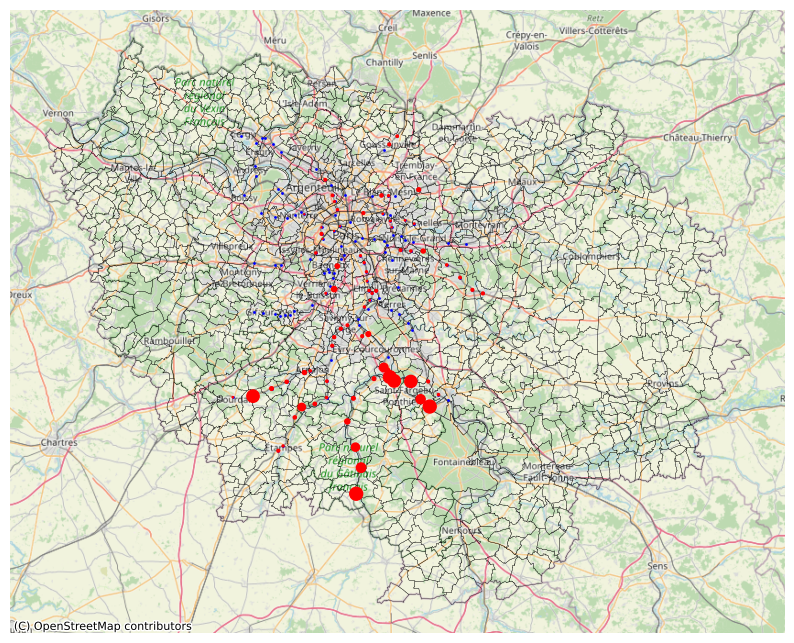

In [32]:
from shapely.geometry import Point

stations_faibles_freq['markersize'] = stations_faibles_freq['Nb de jours avec moins de 50 validations'] * 0.5

fig, ax = plt.subplots(figsize=(10, 10))

shp_communes.to_crs(3857).plot(ax=ax, zorder=1, edgecolor="black",
                               facecolor="none", color=None, linewidth=0.2)

stations = gpd.GeoDataFrame(stations, geometry=[Point(xy) for xy in zip(stations.x, stations.y)])
stations_faibles_freq = gpd.GeoDataFrame(stations_faibles_freq, geometry=[Point(xy) for xy in zip(stations_faibles_freq.x, stations_faibles_freq.y)])
# Tracez les points des stations avec la taille proportionnelle
stations.to_crs(3857).plot(ax=ax, markersize=1, color='blue')
stations_faibles_freq.to_crs(3857).plot(ax=ax, markersize=stations_faibles_freq['markersize'], color='red')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

Cela confirme en partie notre intuition : dans l'ensemble des stations les moins fréquentées, celles qui le sont le moins sont les plus loin de Paris.

Les points bleus correspondent à toutes les stations de *RER*. On observe qu'il y a cependant des stations très éloignées pour lesquelles il y a toujours au moins 100 personnes qui valident tous les jours. Ce n'est pas qu'une question de distance : le croisement avec les données socio-démographiques pourra peut être nous donner plus de précisions par la suite.

#### Stations de RER très fréquentées
On condière qu'une station de *RER* est très fréquentée lorsqu'il y a plus de 10 000 validations par jour (80% quantile).

In [33]:
freq_stations['NB_VALD'].quantile(0.80)

9447.400000000005

In [34]:
haute_freq=freq_stations[freq_stations['NB_VALD'] >= 10000]
haute_freq

JOUR                  nom_long  NB_VALD
40    2023-01-01              Gare de Lyon    50846
73    2023-01-01                   Magenta    33867
150   2023-01-02                     Auber    14825
151   2023-01-02          Aulnay-sous-Bois    13785
169   2023-01-02          Cergy-Préfecture    11110
...          ...                       ...      ...
26578 2023-06-30                     Torcy    12989
26580 2023-06-30           Val de Fontenay    22260
26581 2023-06-30      Versailles-Chantiers    17100
26585 2023-06-30  Villeneuve-Saint-Georges    13760
26590 2023-06-30                 Vincennes    19256

[4963 rows x 3 columns]

In [35]:
haute_freq['NB_VALD'].describe()

count      4963.000000
mean      22469.564578
std       20317.984389
min       10000.000000
25%       13029.500000
50%       16956.000000
75%       22249.000000
max      143557.000000
Name: NB_VALD, dtype: float64

Dans les stations les plus fréquentées on observe une très grande hétérogénéité. Identifions ces stations pour mieux comprendre leurs caractéristiques.

In [36]:
haute_freq_stations=haute_freq.loc[:,['nom_long']]
liste_haute_freq_stations= haute_freq_stations['nom_long'].value_counts()
liste_haute_freq_stations

nom_long
Gare de Lyon                               181
Magenta                                    181
Nation                                     180
Saint-Denis                                180
Denfert-Rochereau                          178
Juvisy                                     174
Noisy-le-Grand-Mont d'Est                  162
Aulnay-sous-Bois                           161
Porte de Clichy                            156
Vincennes                                  153
Neuilly-Plaisance                          151
Auber                                      149
Val de Fontenay                            149
Le Bourget                                 149
Villeneuve-Saint-Georges                   144
Melun                                      136
Saint-Germain-en-Laye                      129
Cergy-Préfecture                           126
Versailles-Chantiers                       123
Saint-Ouen                                 122
Torcy                                      122
Ruei

Il y a donc 84 stations pour lesquelles il y a au moins 1 jour au premier semestre 2023 où il y a plus de 10 000 validations.

On retrouve les très grandes gares parisinnes où il y avait plus de 10 000 validation sur l'ensemble des jours du premier semestre 2023 : Gare du Nord, Châtelet et Gare de Lyon. Le pôle de la Défense fait également partie des stations avec de très hautes fréquentations : son attractivité ne se réduit pas à son bassin d'emploi.

In [37]:
df=liste_haute_freq_stations.reset_index()
df.columns=['Station de RER', 'Nb de jours avec plus de 10000 validations']
liste_haute_freq_stations=df.merge(stations, left_on="Station de RER", right_on="nom_long")

In [38]:
couleurs_res_com = {
    'RER A': 'red', 'RER B': 'blue', 'RER C': 'yellow',
    'RER D': 'green', 'RER E': 'pink', 'RER E, RER A': 'black',
    'RER A, RER B, RER D': 'black', 'RER D, RER A':'black', 
    'RER B, RER D, RER E': 'black', 'RER C, RER D':'black',
    'RER B, RER C':'black', 'RER C, RER B':'black', 'RER E, RER B, RER D': 'black',
    'RER D, RER C' : 'black', 'RER A, RER E': 'black'}

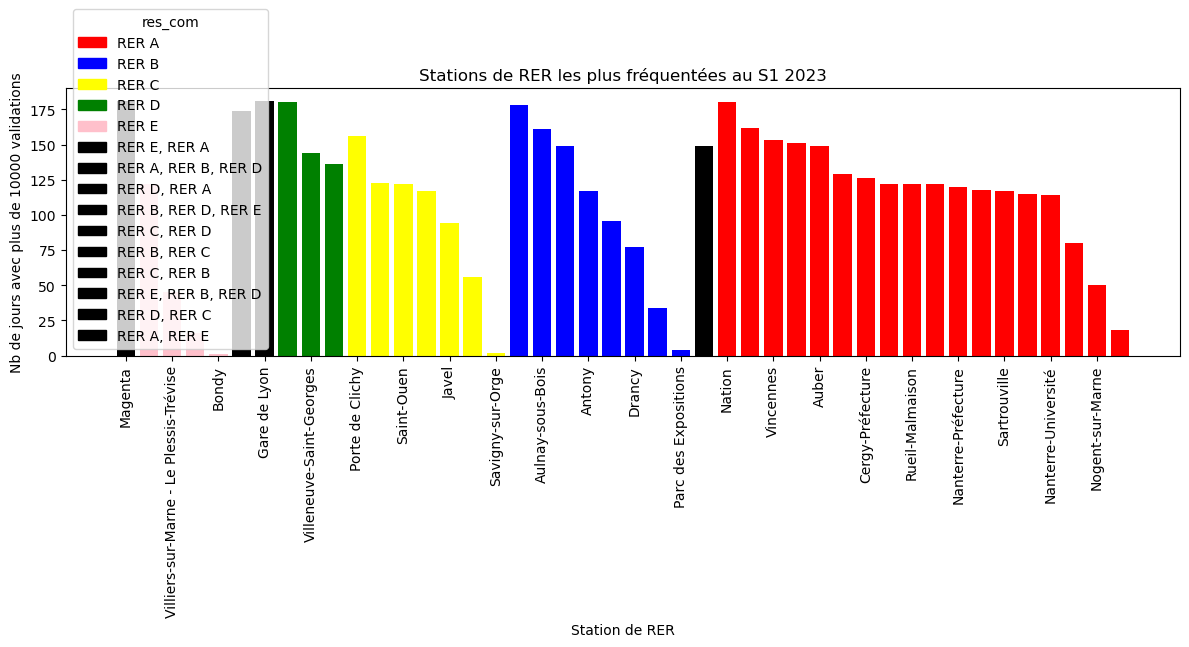

In [39]:
liste_haute_freq_stations2 = liste_haute_freq_stations.sort_values(by=['res_com', 'Nb de jours avec plus de 10000 validations'], ascending=False)

# Créez un graphique à barres avec Matplotlib en utilisant la couleur dépendante de res_com
plt.figure(figsize=(12, 6))
x = range(len(liste_haute_freq_stations2))  # Créez une séquence pour l'axe des abscisses
plt.bar(x, liste_haute_freq_stations2['Nb de jours avec plus de 10000 validations'],
        color=[couleurs_res_com[res] for res in liste_haute_freq_stations2['res_com']])

# Ajustez les étiquettes de l'axe des abscisses pour n'afficher qu'une station sur trois
n = 2
plt.xticks(x[::n], liste_haute_freq_stations2['Station de RER'][::n], rotation=90)

plt.title('Stations de RER les plus fréquentées au S1 2023')
plt.xlabel('Station de RER')
plt.ylabel('Nb de jours avec plus de 10000 validations')

# Créez une légende pour les catégories de res_com
handles = [plt.Rectangle((0, 0), 1, 1, color=couleurs_res_com[res]) for res in couleurs_res_com]
labels = couleurs_res_com.keys()
plt.legend(handles, labels, title='res_com')

# Affichez le graphique
plt.tight_layout()
plt.show()

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

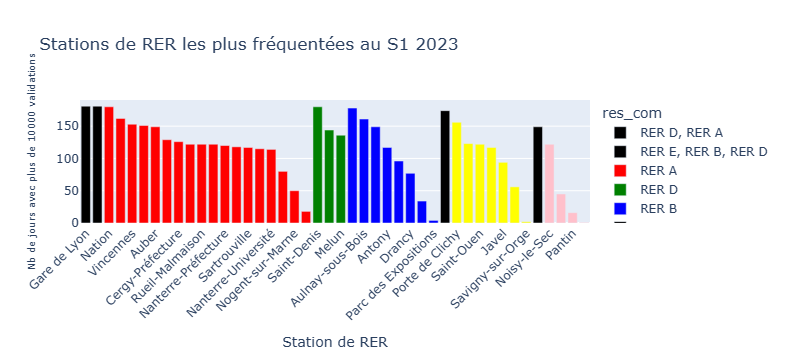

In [40]:
fig = px.bar(liste_haute_freq_stations, x='Station de RER', y='Nb de jours avec plus de 10000 validations', color='res_com',
             title='Stations de RER les plus fréquentées au S1 2023',
            color_discrete_map=couleurs_res_com)

# Personnaliser le graphique
fig.update_layout(xaxis_tickangle=-45)  # Incliner les étiquettes de l'axe des abscisses
#fig.update_traces(marker_color='skyblue')  # La couleur par défaut des barres, peut être écrasée par 'color'
fig.update_yaxes(title_font=dict(size=10))  # Réduire la taille de la police pour l'axe des ordonnées

# Afficher le graphique
fig.show()

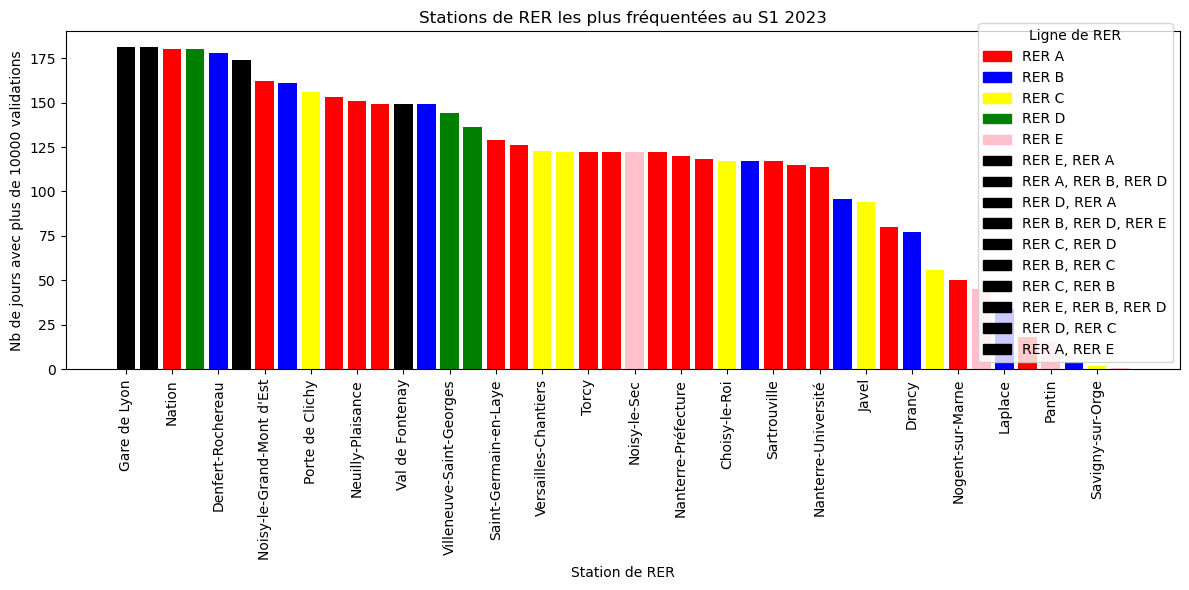

In [41]:
plt.figure(figsize=(12, 6))
x = liste_haute_freq_stations.index  # Utilisez l'indice du DataFrame comme abscisses
plt.bar(x, liste_haute_freq_stations['Nb de jours avec plus de 10000 validations'],
        color=[couleurs_res_com[res] for res in liste_haute_freq_stations['res_com']])

# Ajustez les étiquettes de l'axe des abscisses pour n'afficher qu'une station sur trois
n = 2
plt.xticks(x[::n], liste_haute_freq_stations['Station de RER'][::n], rotation=90)

plt.title('Stations de RER les plus fréquentées au S1 2023')
plt.xlabel('Station de RER')
plt.ylabel('Nb de jours avec plus de 10000 validations')

# Créez une légende pour les catégories de res_com
handles = [plt.Rectangle((0, 0), 1, 1, color=couleurs_res_com[res]) for res in couleurs_res_com]
labels = couleurs_res_com.keys()
plt.legend(handles, labels, title='Ligne de RER')

# Affichez le graphique
plt.tight_layout()
plt.show()

*Un graphique interactif est disponible ci dessous, accessible sur un NoteBook*.

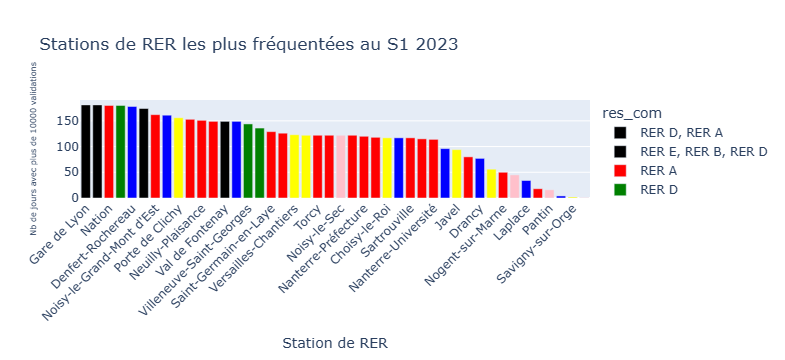

In [42]:
# Trier le DataFrame par 'Nb de jours avec moins de 50 validations' en ordre décroissant
df_sorted = liste_haute_freq_stations.sort_values(by='Nb de jours avec plus de 10000 validations', ascending=False)

# Créer un graphique en barres interactif avec des couleurs conditionnelles
fig = px.bar(df_sorted, x='Station de RER', y='Nb de jours avec plus de 10000 validations', color='res_com',
             title='Stations de RER les plus fréquentées au S1 2023',
             color_discrete_map=couleurs_res_com,
             category_orders={"Station de RER": df_sorted['Station de RER'].tolist()})  # Définir l'ordre des catégories

# Personnaliser le graphique
fig.update_layout(xaxis_tickangle=-45)
fig.update_yaxes(title_font=dict(size=8))

# Afficher le graphique
fig.show()

Ce sont, sans surprise, les stations avec plusieurs *RER* qui cumullent le plus de journées avec plus de 10 000 validations. Ensuite, chaque *RER* possède ses pôles attracteurs (la Défense, Denfert-Rochereau, Austerlitz, Saint-Denis...). Sur le graphique par ligne on voit très bien que les stations du *RER A* sont les plus fréquentées : c'est effectivelent la ligne de train la plus fréquentée d'Europe.

Sur le graphique on voit également assez clairement la "cassure" entre les stations fréquentées tout le temps, et celles très fréquentées partiellement (principalement la semaine).

Ci-dessus, lorsque l'on regarder les stations les plus fréquentées par jour on retrouve Châtelet : cela est logique puisque l'on a cumulé l'ensemble des validations pour toutes les stations de *RER* et de *métro* du pôle. Afin d'avoir une analyse plus fine on prend le maximum de fréquentation par stations et on les classe par ordre décroissant.

In [43]:
haute_freq.sort_values(by="NB_VALD", ascending=False).head(15)

JOUR      nom_long  NB_VALD
21926 2023-05-30  Gare de Lyon   143557
25168 2023-06-21  Gare de Lyon   142453
18835 2023-05-09  Gare de Lyon   138016
26053 2023-06-27  Gare de Lyon   136086
25020 2023-06-20  Gare de Lyon   135995
6523  2023-02-14  Gare de Lyon   135916
9458  2023-03-06  Gare de Lyon   135478
6671  2023-02-15  Gare de Lyon   134498
23987 2023-06-13  Gare de Lyon   134074
22811 2023-06-05  Gare de Lyon   133982
24872 2023-06-19  Gare de Lyon   133919
5792  2023-02-09  Gare de Lyon   133914
23252 2023-06-08  Gare de Lyon   133558
22222 2023-06-01  Gare de Lyon   133331
2406  2023-01-17  Gare de Lyon   132604

In [44]:
idx = haute_freq.groupby('nom_long')['NB_VALD'].idxmax()

# Utiliser les indices pour récupérer les lignes correspondantes du DataFrame original
result = haute_freq.loc[idx]
result = result.sort_values(by="NB_VALD", ascending=False)

# Afficher le résultat
result.head(15)

JOUR                   nom_long  NB_VALD
21926 2023-05-30               Gare de Lyon   143557
5384  2023-02-06                    Magenta   101716
6130  2023-02-11                     Nation    46739
23393 2023-06-09          Denfert-Rochereau    33584
18408 2023-05-06                     Juvisy    32471
5852  2023-02-09            Porte de Clichy    31037
20109 2023-05-17                  Vincennes    30880
6609  2023-02-14            Val de Fontenay    30447
5419  2023-02-06                Saint-Denis    28552
25481 2023-06-23                 Le Bourget    28078
6571  2023-02-14  Noisy-le-Grand-Mont d'Est    26928
6714  2023-02-15        Nanterre-Université    25261
25062 2023-06-20        Nanterre-Préfecture    24497
6589  2023-02-14            Rueil-Malmaison    23378
14202 2023-04-07       Versailles-Chantiers    23226

Tout d'abord, il est interessant de remarquer qu'un des jours avec le plus grand nombre de validations est le 21 juin, ce qui correspond à la fête de la musique, qui était un mercredi en 2023 : on a donc le cumul de la fréquentation habituelle en plus de celle de cet évènement culturelle.

Sur les 10 stations avec le pic de validation le plus élevé 9 sont situées à Paris. Après la Défense, c'est Juvisy la station de banlieue avec le plus grand nombre de validation (en valeur maximale).

Regardons maintenant si ce constat change lorsque l'on regarde l'on regarde le nombre de validations en cumullé sur le semestre par station.

In [45]:
freq_stations_cum=freq_stations.groupby('nom_long')['NB_VALD'].sum()
freq_stations_cum.sort_values(ascending=False).head(15)

nom_long
Gare de Lyon                 18567245
Magenta                      12886810
Nation                        5925298
Saint-Denis                   4042910
Porte de Clichy               3848362
Juvisy                        3828798
Noisy-le-Grand-Mont d'Est     3620278
Val de Fontenay               3575498
Denfert-Rochereau             3478048
Vincennes                     3430408
Aulnay-sous-Bois              3033580
Neuilly-Plaisance             2920702
Rueil-Malmaison               2787673
Versailles-Chantiers          2751451
Auber                         2746502
Name: NB_VALD, dtype: int64

Le constat reste essentiellement le même lorsque l'on regarde l'ensemble des validations cumulées sur le premier semestre 2023. Cela montre que les stations qui sont très fréquentées le sont de manière très homogène (elles restent très fréquentées quelque soit le jour).

In [46]:
stations_hautes_freq=stations.merge(freq_stations_cum, how='right', 
                                    right_on="nom_long", left_on='nom_long')

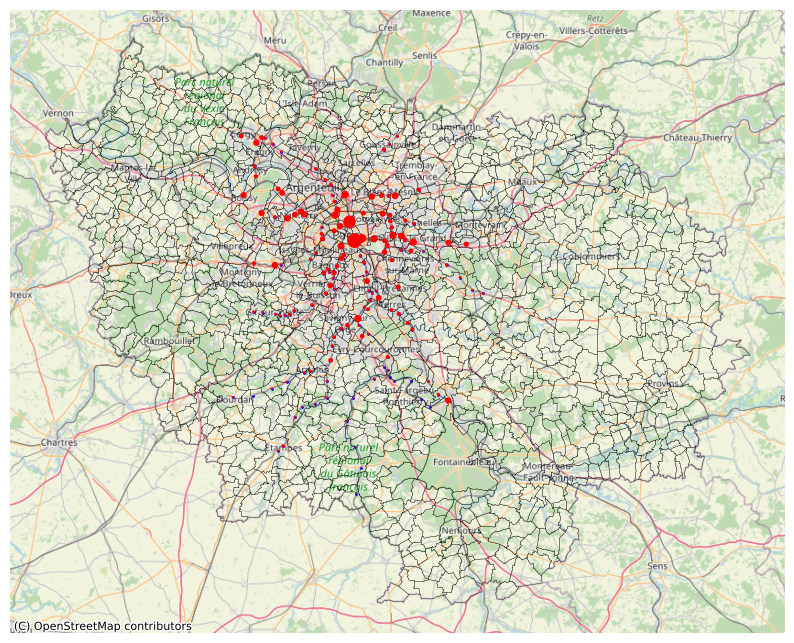

In [47]:
stations_hautes_freq['markersize'] = stations_hautes_freq['NB_VALD'] * 0.000005

fig, ax = plt.subplots(figsize=(10, 10))

shp_communes.to_crs(3857).plot(ax=ax, zorder=1, edgecolor="black",
                               facecolor="none", color=None, linewidth=0.2)

# Tracez les points des stations avec la taille proportionnelle
stations.to_crs(3857).plot(ax=ax, markersize=1, color='blue')
stations_hautes_freq.to_crs(3857).plot(ax=ax, markersize=stations_hautes_freq['markersize'], color='red')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

La carte ci-dessus représente un point rouge de taille proportionnelle aux validations cumulés sur l'ensemble du premier semestre 2023.

On retrouve le constat que nous avions fait avec les stations les moins fréquentées mais de manière plus rafiné : les stations les plus fréquentées sont relativement proches de Paris à l'exception de quelques pôles attracteurs dont on peut penser qu'ils sont denses et très bien déservis.

### Fréquentation par titre de transport

In [48]:
freq_titre=data.groupby('CATEGORIE_TITRE')['NB_VALD'].sum()
freq_titre=freq_titre.sort_values()
freq_titre

CATEGORIE_TITRE
NAVIGO JOUR      477972
AMETHYSTE       3216614
AUTRE TITRE     4031009
FGT             6345911
NON DEFINI      8925564
TST            16817117
IMAGINE R      36822869
NAVIGO         97588829
Name: NB_VALD, dtype: int64

In [49]:
freq_titre.describe()

count    8.000000e+00
mean     2.177824e+07
std      3.276485e+07
min      4.779720e+05
25%      3.827410e+06
50%      7.635738e+06
75%      2.181856e+07
max      9.758883e+07
Name: NB_VALD, dtype: float64

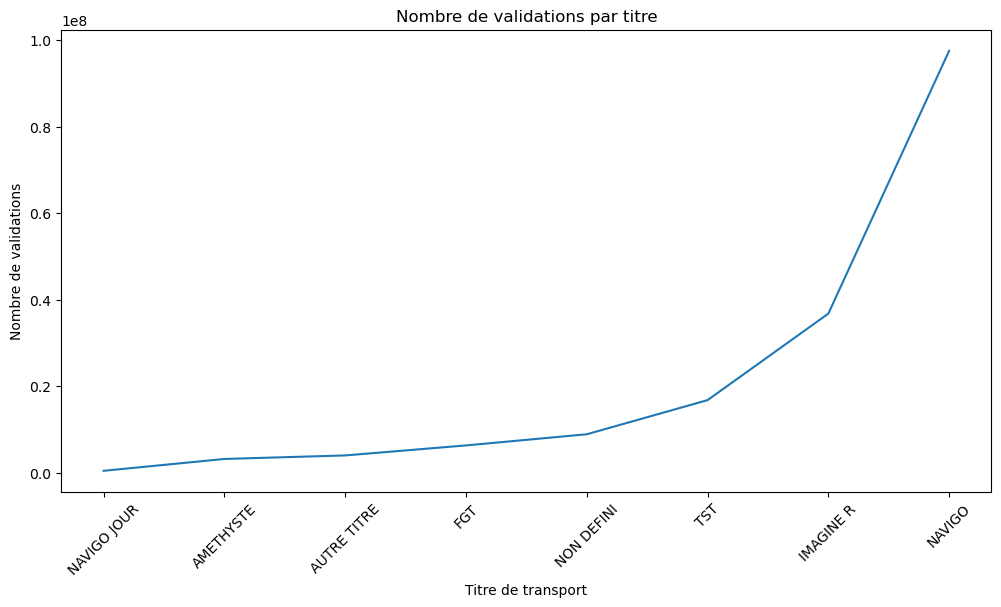

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(freq_titre)
plt.xticks(rotation=45)
plt.title('Nombre de validations par titre')
plt.xlabel('Titre de transport')
plt.ylabel('Nombre de validations')
plt.show()

In [51]:
(183180849+73148912)/freq_titre.sum()

1.4712495849856064

Le pass Navigo représente une très grande partie des validations sur le réseau *RER*. Si l'on ajoute les validations des pass Imagine R cela représente presque 80% de l'ensemble des validations, soit une très large majorité.

In [52]:
freq_titre_station=data.groupby(['CATEGORIE_TITRE', 'nom_long'])['NB_VALD'].sum()
freq_titre_station=pd.DataFrame(freq_titre_station)
freq_titre_station

NB_VALD
CATEGORIE_TITRE nom_long                 
AMETHYSTE       Ablon                4242
                Achères-Ville       13343
                Antony              47055
                Arpajon              3979
                Athis-Mons           3981
...                                   ...
TST             Égly                 2723
                Épinay-sur-Orge     55592
                Épinay-sur-Seine   117461
                Étampes             37232
                Étréchy              3482

[1080 rows x 1 columns]

In [53]:
idx = freq_titre_station.groupby('CATEGORIE_TITRE')['NB_VALD'].idxmax()

# Sélectionnez les lignes correspondant aux index trouvés
stations_top_vald = freq_titre_station.loc[idx]
stations_top_vald

NB_VALD
CATEGORIE_TITRE nom_long              
AMETHYSTE       Gare de Lyon    254837
AUTRE TITRE     Gare de Lyon   1524850
FGT             Magenta         544713
IMAGINE R       Gare de Lyon   3163307
NAVIGO          Gare de Lyon  10624213
NAVIGO JOUR     Gare de Lyon     76678
NON DEFINI      Gare de Lyon   1279284
TST             Magenta        1564759

Ces données semble cohérentes avec tout ce que nous avons vu jusqu'à présent. Nous essayons maintenant de voir s'il y a une différence fondamentale entre les *Navigo* et *Navigo Jour* afin de voir si l'on peut identifier des spécificités lié aux touristes. Cependant, le problème de la classification proposé ici est qu'elle ne sépare pas les Pass Navigo *semaine* et *mois* alors que l'on peut imaginer que ces deux pass ne touchent pas du tout les mêmes publics.

In [54]:
freq_titre_station= freq_titre_station.reset_index()
freq_navigo_jour=freq_titre_station[freq_titre_station['CATEGORIE_TITRE']=='NAVIGO JOUR']
freq_navigo_jour

CATEGORIE_TITRE          nom_long  NB_VALD
636     NAVIGO JOUR             Ablon      817
637     NAVIGO JOUR     Achères-Ville     1241
638     NAVIGO JOUR            Antony     5513
639     NAVIGO JOUR           Arpajon      944
640     NAVIGO JOUR        Athis-Mons      790
..              ...               ...      ...
779     NAVIGO JOUR              Égly      518
780     NAVIGO JOUR   Épinay-sur-Orge     1375
781     NAVIGO JOUR  Épinay-sur-Seine     1793
782     NAVIGO JOUR           Étampes     2149
783     NAVIGO JOUR           Étréchy      629

[148 rows x 3 columns]

In [55]:
freq_navigo_jour.sort_values(by='NB_VALD', ascending=False).head(15)

CATEGORIE_TITRE                   nom_long  NB_VALD
678     NAVIGO JOUR               Gare de Lyon    76678
712     NAVIGO JOUR                    Magenta    43273
641     NAVIGO JOUR                      Auber    13722
672     NAVIGO JOUR          Denfert-Rochereau    12314
723     NAVIGO JOUR                     Nation    11331
744     NAVIGO JOUR            Rueil-Malmaison    10212
690     NAVIGO JOUR                     Juvisy    10065
716     NAVIGO JOUR                      Melun     9857
765     NAVIGO JOUR       Versailles-Chantiers     9545
726     NAVIGO JOUR  Noisy-le-Grand-Mont d'Est     8343
724     NAVIGO JOUR          Neuilly-Plaisance     8106
749     NAVIGO JOUR      Saint-Germain-en-Laye     7870
774     NAVIGO JOUR                  Vincennes     7854
764     NAVIGO JOUR            Val de Fontenay     7305
738     NAVIGO JOUR            Porte de Clichy     6641

Les constats sont relativement simialaires, les gares grandes lignes sont un peu plus présentes dans les stations les plus fréquentées (ce sont en effet des points d'entrées important pour ceux qui n'habitent pas en région parisienne). Il semble ainsi difficile de mettre en avant des comportements différents : soit parce que ces comportements sont similaires, soit parce qu'ils sont trop minortaires et donc plus difficillement détectables.

On regarde maintenant les variations par mois de la répartition du nombre de validations par titre de transport.

*La graphique suivant est interactif et utilisable depuis un NoteBook.*

In [56]:
vald_23_RER_mois_categorie=data.groupby(['CATEGORIE_TITRE', 'Mois'])['NB_VALD'].sum()
vald_23_RER_mois_categorie=pd.DataFrame(vald_23_RER_mois_categorie).reset_index()

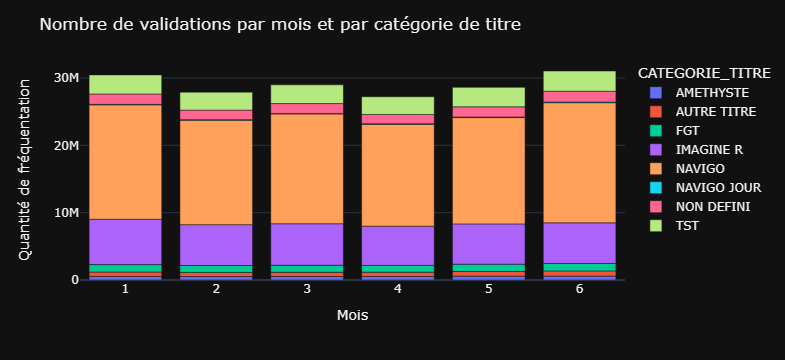

In [57]:
# graphe par mois de la fréquentation associée à chaque type de titre de transport

fig = px.bar(vald_23_RER_mois_categorie, x='Mois', y='NB_VALD', color='CATEGORIE_TITRE',
             labels={'NB_VALD': 'Nombre de validations', 'Mois': 'Mois'})

fig.update_layout(
    title='Nombre de validations par mois et par catégorie de titre',
    xaxis_title='Mois',
    yaxis_title='Quantité de fréquentation',
    template='plotly_dark',  
)

fig.show()

## Sur les carreaux INSEE

L'intérêt de cette section est surtout de croiser les données de validation de RER avec les données socio-démographiques de l'INSEE, ce qui sera approfondi dans le notebook "Statistiques bivariées"

In [58]:
from IPython.utils import io
from io import BytesIO  
from _pre_proces_Insee_IDFM import data_INSEE_stations

with io.capture_output() as captured:
    stations_socio_RER=data_INSEE_stations()


On ne retient que les colonnes qui nous paraissent intéressantes pour l'analyse

In [59]:
stations_socio_RER.loc[:,["ind", "men", "men_pauv", "men_1ind", "men_5ind", 'men_prop', 'men_fmp', 'ind_snv',
       'men_surf', 'men_coll', 'men_mais', 'log_soc', 'ind_0_3', 'ind_4_5',
       'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39', 'ind_40_54',
       'ind_55_64', 'ind_65_79', 'ind_80p']].describe()


ind           men     men_pauv      men_1ind     men_5ind  \
count    244.000000    244.000000   244.000000    244.000000   244.000000   
mean    7232.172131   3220.303279   471.777869   1328.230328   260.459016   
std     6633.462779   3334.417251   551.514590   1705.328952   234.819328   
min        0.000000      0.000000     0.000000      0.000000     0.000000   
25%     2551.375000   1030.750000    99.250000    339.025000    98.750000   
50%     6100.000000   2476.100000   289.950000    827.500000   210.550000   
75%     8995.625000   3818.750000   650.000000   1554.000000   359.250000   
max    35842.500000  19389.000000  2735.000000  10430.000000  1663.000000   

          men_prop      men_fmp       ind_snv      men_surf      men_coll  \
count   244.000000   244.000000  2.440000e+02  2.440000e+02    244.000000   
mean   1326.236475   360.177869  2.163416e+08  2.124567e+05   2751.859836   
std    1236.067636   313.377584  2.499235e+08  2.016849e+05   3345.882831   
min       0.000000     0.000000  0.000000e+00  0.000000e+00      0.000000   
25%     529.175000   130.750000  6.877950e+07  8.281250e+04    613.250000   
50%    1010.000000   282.000000  1.448938e+08  1.706299e+05   1837.500000   
75%    1643.500000   481.325000  2.457305e+08  2.526388e+05   3374.250000   
max    7360.000000  1648.000000  1.495966e+09  1.247443e+06  19313.000000   

       ...      ind_0_3     ind_4_5     ind_6_10    ind_11_17    ind_18_24  \
count  ...   244.000000  244.000000   244.000000   244.000000   244.000000   
mean   ...   374.928279  188.276230   454.956148   595.940164   535.145082   
std    ...   313.095928  151.106349   364.672326   494.401102   465.869163   
min    ...     0.000000    0.000000     0.000000     0.000000     0.000000   
25%    ...   127.150000   70.675000   176.875000   225.500000   208.250000   
50%    ...   328.200000  163.700000   402.500000   526.500000   449.250000   
75%    ...   510.125000  264.250000   613.500000   754.625000   680.500000   
max    ...  1932.500000  783.500000  2097.500000  2850.500000  2634.000000   

          ind_25_39    ind_40_54    ind_55_64    ind_65_79      ind_80p  
count    244.000000   244.000000   244.000000   244.000000   244.000000  
mean    1736.110246  1456.206148   790.859426   769.634836   312.756967  
std     1841.602016  1344.682590   744.943247   811.415613   359.154569  
min        0.000000     0.000000     0.000000     0.000000     0.000000  
25%      537.450000   515.750000   269.925000   259.475000    93.850000  
50%     1388.000000  1223.500000   639.050000   540.050000   197.500000  
75%     2148.000000  1788.000000  1003.500000   893.000000   375.225000  
max    12049.000000  6872.000000  3851.000000  4452.000000  2229.000000  

[8 rows x 22 columns]

Pour simplifier l'analyse, on regroupe les individus en 4 catégories d'âge : enfant, jeune, adulte, vieux.

In [60]:
stations_socio_RER['enfant'] = stations_socio_RER['ind_0_3'] + stations_socio_RER['ind_4_5'] + stations_socio_RER['ind_6_10']
stations_socio_RER['jeune'] = stations_socio_RER['ind_11_17'] + stations_socio_RER['ind_18_24']
stations_socio_RER['adulte'] = stations_socio_RER['ind_25_39'] + stations_socio_RER['ind_40_54'] + stations_socio_RER['ind_55_64']
stations_socio_RER['vieux'] = stations_socio_RER['ind_65_79']  + stations_socio_RER['ind_80p']
stations_socio_RER.drop(columns = ['ind_0_3', 'ind_4_5',
       'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39', 'ind_40_54',
       'ind_55_64', 'ind_65_79', 'ind_80p'])

Geo Point  \
0      48.93230541513496, 2.475674370833511   
1     48.955402243597064, 2.093521901580611   
2      49.03646397979169, 2.079534939997373   
3      48.56494949473517, 2.594551816007612   
4    48.861822271863645, 2.3470126872387564   
..                                      ...   
249  48.962709512366416, 2.5126446278196126   
250  48.869950134005364, 2.7822267234490363   
251   49.00975645120457, 2.5612326952251054   
252   48.97342490628139, 2.5143602855334923   
253     49.00468746087186, 2.57058948552452   

                                             Geo Shape  gares_id  \
0    {"coordinates": [2.475674370833511, 48.9323054...        77   
1    {"coordinates": [2.093521901580611, 48.9554022...         4   
2    {"coordinates": [2.079534939997373, 49.0364639...       129   
3    {"coordinates": [2.594551816007612, 48.5649494...       135   
4    {"coordinates": [2.347012687238756, 48.8618222...       163   
..                                                 ...       ...   
249  {"coordinates": [2.512644627819613, 48.9627095...       905   
250  {"coordinates": [2.782226723449036, 48.8699501...       182   
251  {"coordinates": [2.561232695225105, 49.0097564...       743   
252  {"coordinates": [2.514360285533492, 48.9734249...       621   
253  {"coordinates": [2.57058948552452, 49.00468746...       744   

                             nom_long nom_so_gar nom_su_gar  id_ref_ZdC  \
0                     Le Blanc-Mesnil        NaN        NaN       72648   
1               Achères-Grand-Cormier        NaN        NaN       65190   
2                    Cergy-Préfecture        NaN        NaN       66696   
3                              Cesson        NaN        NaN       62176   
4                 Châtelet-Les Halles        NaN        NaN      474151   
..                                ...        ...        ...         ...   
249                        Villepinte        NaN        NaN       73547   
250            Marne-la-Vallée-Chessy        NaN        NaN       68385   
251      Aéroport Charles De Gaulle 1        NaN        NaN       73596   
252              Parc des Expositions        NaN        NaN       73568   
253  Aéroport Charles De Gaulle 2-TGV        NaN        NaN       73699   

                             nom_ZdC  id_ref_ZdA  \
0                    Le Blanc-Mesnil       46163   
1              Achères Grand Cormier       47915   
2                   Cergy Préfecture       44559   
3                             Cesson       42516   
4                Châtelet les Halles       45102   
..                               ...         ...   
249                       Villepinte       58793   
250           Marne-la-Vallée Chessy       43239   
251      Aéroport CDG 1 (Terminal 3)      462398   
252             Parc des Expositions       47878   
253  Aéroport CDG - Terminal 2 (TGV)      473364   

                                       nom_ZdA  ... log_soc ind_inc pre_IDF  \
0                              Le Blanc-Mesnil  ...  1082.0    18.0     1.0   
1                        Achères Grand Cormier  ...     4.7     0.0     1.0   
2                             Cergy Préfecture  ...   698.1    26.0     1.0   
3                                       Cesson  ...    75.0     3.0     1.0   
4                          Châtelet les Halles  ...  1497.0    20.0     1.0   
..                                         ...  ...     ...     ...     ...   
249                                 Villepinte  ...     0.0     NaN     NaN   
250                     Marne-la-Vallée Chessy  ...     0.0     NaN     NaN   
251          Aéroport CDG 1 (Terminal 3) - RER  ...     0.0     NaN     NaN   
252                       Parc des Expositions  ...     0.0     NaN     NaN   
253  Aéroport Charles de Gaulle 2 (Terminal 2)  ...     0.0     NaN     NaN   

    select expt               enfant   jeune   adulte   vieux  
0      1.0  1.0          NaN  1221.0  1203.5   3538.0   813.0  
1      1.0  1.0          NaN    20.7    27.8     

Text(0, 0.5, 'Fréquence')

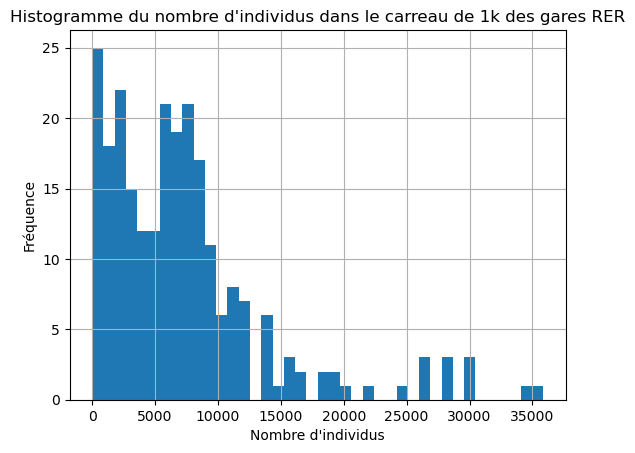

In [61]:
stations_socio_RER["ind"].hist(bins=40)
plt.title("Histogramme du nombre d'individus dans le carreau de 1k des gares RER")
plt.xlabel("Nombre d'individus")
plt.ylabel("Fréquence")



Text(0, 0.5, 'Fréquence')

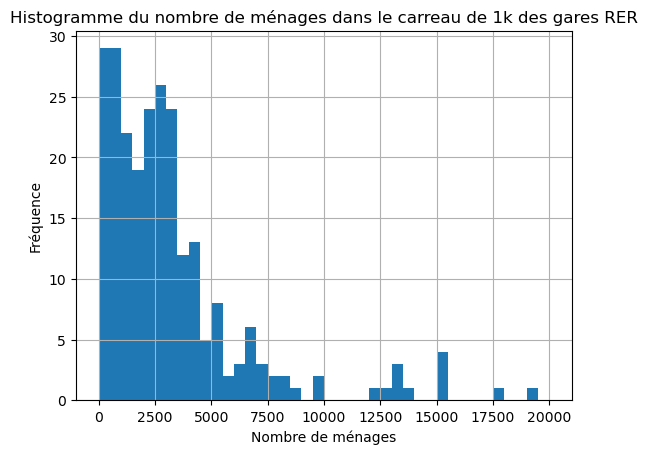

In [62]:
stations_socio_RER["men"].hist(bins=40, range=(0,20000))
plt.title("Histogramme du nombre de ménages dans le carreau de 1k des gares RER")
plt.xlabel("Nombre de ménages")
plt.ylabel("Fréquence")

Text(0, 0.5, 'Fréquence')

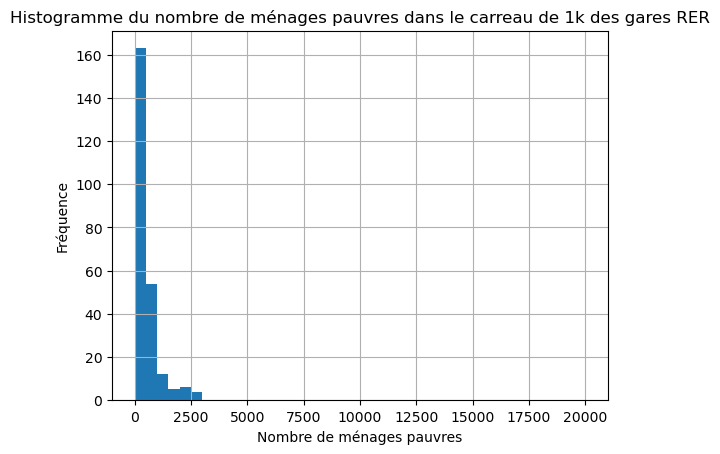

In [63]:
stations_socio_RER["men_pauv"].hist(bins=40, range=(0,20000))
plt.title("Histogramme du nombre de ménages pauvres dans le carreau de 1k des gares RER")
plt.xlabel("Nombre de ménages pauvres")
plt.ylabel("Fréquence")

In [64]:
stations_socio_RER.columns

Index(['Geo Point', 'Geo Shape', 'gares_id', 'nom_long', 'nom_so_gar',
       'nom_su_gar', 'id_ref_ZdC', 'nom_ZdC', 'id_ref_ZdA', 'nom_ZdA',
       'idrefliga', 'idrefligc', 'res_com', 'indice_lig', 'mode_', 'tertrain',
       'terrer', 'termetro', 'tertram', 'terval', 'exploitant', 'idf',
       'principal', 'x', 'y', 'picto ligne', 'nom_iv', 'geometry',
       'index_right', 'idcar_1km', 'i_est_1km', 'lcog_geo', 'ind', 'men',
       'men_pauv', 'men_1ind', 'men_5ind', 'men_prop', 'men_fmp', 'ind_snv',
       'men_surf', 'men_coll', 'men_mais', 'log_av45', 'log_45_70',
       'log_70_90', 'log_ap90', 'log_inc', 'log_soc', 'ind_0_3', 'ind_4_5',
       'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39', 'ind_40_54',
       'ind_55_64', 'ind_65_79', 'ind_80p', 'ind_inc', 'pre_IDF', 'select',
       'expt', '', 'enfant', 'jeune', 'adulte', 'vieux'],
      dtype='object')

On peut regarder comment, en moyenne, sont populés les carreaux de l'INSEE en fonction de la catégorie des individus :

In [65]:
jeune_moy = (stations_socio_RER['jeune']/stations_socio_RER['ind']).mean()
print(f'Il y a en moyenne {round(jeune_moy,2)*100} % de jeunes dans chaque carreau')
adulte_moy = (stations_socio_RER['adulte']/stations_socio_RER['ind']).mean()
print(f'Il y a en moyenne {round(adulte_moy,2)*100} % d adulte dans chaque carreau')
enfant_moy = (stations_socio_RER['enfant']/stations_socio_RER['ind']).mean()
print(f'Il y a en moyenne {round(enfant_moy,2)*100} % de enfant dans chaque carreau')
vieux_moy = (stations_socio_RER['vieux']/stations_socio_RER['ind']).mean()
print(f'Il y a en moyenne {round(vieux_moy,2)*100} % de vieux dans chaque carreau')

Il y a en moyenne 16.0 % de jeunes dans chaque carreau
Il y a en moyenne 54.0 % d adulte dans chaque carreau
Il y a en moyenne 15.0 % de enfant dans chaque carreau
Il y a en moyenne 15.0 % de vieux dans chaque carreau


## Sur le profil horaire

### Prise en main de la base et nettoyage


In [66]:
# import des packages
from _importation_donnees import donnees_profils_23
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# importation de la base de données 2023
profils_23=donnees_profils_23()


In [68]:
profils_23

CODE_STIF_TRNS CODE_STIF_RES CODE_STIF_ARRET    LIBELLE_ARRET    lda  \
0                 100           110             300         GALLIENI  71817   
1                 100           110             300         GALLIENI  71817   
2                 100           110             300         GALLIENI  71817   
3                 100           110             300         GALLIENI  71817   
4                 100           110             300         GALLIENI  71817   
...               ...           ...             ...              ...    ...   
84132             800           852              62         BELLEVUE  69528   
84133             800           852             657  PLAISIR GRIGNON  64199   
84134             800           852             657  PLAISIR GRIGNON  64199   
84135             800           852             657  PLAISIR GRIGNON  64199   
84136             800           852             657  PLAISIR GRIGNON  64199   

      CAT_JOUR TRNC_HORR_60  pourc_validations  
0         JOVS       23H-0H               0.82  
1         SAHV      12H-13H               6.63  
2         SAHV      16H-17H               7.49  
3         SAHV      21H-22H               2.81  
4         SAHV        3H-4H               0.00  
...        ...          ...                ...  
84132     SAVS        6H-7H               1.84  
84133    DIJFP      17H-18H               8.30  
84134    DIJFP        5H-6H               0.31  
84135    DIJFP        8H-9H               4.92  
84136     JOHV      14H-15H               3.02  

[84137 rows x 8 columns]

Les CAT_JOUR sont les suivantes : - JOVS : Jour ouvré en vacances scolaires - JOHV : Jour ouvré hors vacances - SAHV : Samedi hors vacances - SAVS : Samedi en vacances scolaires - DIJFP : Dimanche et jours fériés

Pour une même station, on a donc normalement 24*5 = 120 lignes, mais on remarque que certaines lignes manquent (exemple sur la station Gallieni qui compte 119 lignes, avec la tranche horaire 3h-4h en SAVS manquante).


In [69]:
_0 = profils_23[profils_23['pourc_validations'] == 0.00]
len(_0)



3001

Ces valeurs manquantes ne sont pas dûes à une absence de validation : on a bien des lignes qui apparaissent à des tranches horaires vides. Mais en moyenne, a-t-on bien un pourcentage de validations par jour de 100 (ie pas de NA?)


In [70]:
cat_jour = profils_23.groupby(['lda', 'CAT_JOUR'])['pourc_validations'].sum()
cat_jour



lda     CAT_JOUR
59403   DIJFP       100.00
        JOHV        100.00
        JOVS        100.02
        SAHV         99.99
        SAVS        100.02
                     ...  
999999  DIJFP       200.00
        JOHV        200.02
        JOVS        199.99
        SAHV        199.97
        SAVS        200.02
Name: pourc_validations, Length: 3630, dtype: float64

Les valeurs qui n'atteignent pas parfaitement 100 sont certainements duês à une approximation dans l'arrondi des pourcentages. Cependant, on remarque une curieuse valeur pour le "lda" 999999 ...

In [71]:
lda_chelou = profils_23[profils_23['lda'] == 999999]
lda_chelou

CODE_STIF_TRNS CODE_STIF_RES CODE_STIF_ARRET LIBELLE_ARRET     lda  \
2966              100            ND              ND       Inconnu  999999   
2967              100            ND              ND       Inconnu  999999   
2968              100            ND              ND       Inconnu  999999   
2969              100            ND              ND       Inconnu  999999   
2970              100            ND              ND       Inconnu  999999   
...               ...           ...             ...           ...     ...   
81372             100            ND              ND       Inconnu  999999   
81373             100            ND              ND       Inconnu  999999   
81374             100            ND              ND       Inconnu  999999   
81375             100            ND              ND       Inconnu  999999   
81376             100            ND              ND       Inconnu  999999   

      CAT_JOUR TRNC_HORR_60  pourc_validations  
2966     DIJFP        1H-2H               0.06  
2967     DIJFP      20H-21H               5.90  
2968      JOHV        0H-1H               0.60  
2969      JOHV      12H-13H               4.18  
2970      JOHV      13H-14H               4.29  
...        ...          ...                ...  
81372     SAVS      18H-19H              10.59  
81373     SAVS      19H-20H               6.91  
81374     SAVS      21H-22H               3.39  
81375     SAVS       23H-0H               3.30  
81376     SAVS       9H-10H               3.41  

[135 rows x 8 columns]

En l'absence d'informations supplémentaires sur ces lda, il ne semble par pertinent de traiter ces stations : on les exclut donc du dataframe.

In [72]:
profils_23_clean = profils_23[profils_23['lda'] != 999999]
profils_23_clean

CODE_STIF_TRNS CODE_STIF_RES CODE_STIF_ARRET    LIBELLE_ARRET    lda  \
0                 100           110             300         GALLIENI  71817   
1                 100           110             300         GALLIENI  71817   
2                 100           110             300         GALLIENI  71817   
3                 100           110             300         GALLIENI  71817   
4                 100           110             300         GALLIENI  71817   
...               ...           ...             ...              ...    ...   
84132             800           852              62         BELLEVUE  69528   
84133             800           852             657  PLAISIR GRIGNON  64199   
84134             800           852             657  PLAISIR GRIGNON  64199   
84135             800           852             657  PLAISIR GRIGNON  64199   
84136             800           852             657  PLAISIR GRIGNON  64199   

      CAT_JOUR TRNC_HORR_60  pourc_validations  
0         JOVS       23H-0H               0.82  
1         SAHV      12H-13H               6.63  
2         SAHV      16H-17H               7.49  
3         SAHV      21H-22H               2.81  
4         SAHV        3H-4H               0.00  
...        ...          ...                ...  
84132     SAVS        6H-7H               1.84  
84133    DIJFP      17H-18H               8.30  
84134    DIJFP        5H-6H               0.31  
84135    DIJFP        8H-9H               4.92  
84136     JOHV      14H-15H               3.02  

[84002 rows x 8 columns]

In [73]:
profils_23_clean1 = profils_23_clean.drop(columns = ['CODE_STIF_TRNS', 'CODE_STIF_ARRET']) 
profils_23_clean1
noms = ['rer', 'arret', 'lda', 'cat_jour', 'horaire', '%_val']

In [74]:
profils_23_clean1.columns = noms
profils_23_clean1

rer            arret    lda cat_jour  horaire  %_val
0      110         GALLIENI  71817     JOVS   23H-0H   0.82
1      110         GALLIENI  71817     SAHV  12H-13H   6.63
2      110         GALLIENI  71817     SAHV  16H-17H   7.49
3      110         GALLIENI  71817     SAHV  21H-22H   2.81
4      110         GALLIENI  71817     SAHV    3H-4H   0.00
...    ...              ...    ...      ...      ...    ...
84132  852         BELLEVUE  69528     SAVS    6H-7H   1.84
84133  852  PLAISIR GRIGNON  64199    DIJFP  17H-18H   8.30
84134  852  PLAISIR GRIGNON  64199    DIJFP    5H-6H   0.31
84135  852  PLAISIR GRIGNON  64199    DIJFP    8H-9H   4.92
84136  852  PLAISIR GRIGNON  64199     JOHV  14H-15H   3.02

[84002 rows x 6 columns]

On enlève les colonnes qui ne sont pas intéressantes pour l'analyse: SITF_TRNS et SITF_ARRET, et on renomme les autres de manière plus simple et intuitive

On travaille ici sur les RER, dont les codes SITF_RES sont respectivement 801, 802, 803, 804, et 805 : on ne garde donc que ces valeurs.


In [75]:
rer_stif = ['801', '802', '803', '804', '805']
profils_23_0 = profils_23_clean1[profils_23_clean1['rer'].isin(rer_stif)]
profils_23_0.loc[profils_23_0['rer'] == '801', 'rer'] = 'RER A'
profils_23_0.loc[profils_23_0['rer'] == '802', 'rer'] = 'RER B'
profils_23_0.loc[profils_23_0['rer'] == '803', 'rer'] = 'RER C'
profils_23_0.loc[profils_23_0['rer'] == '804', 'rer'] = 'RER D'
profils_23_0.loc[profils_23_0['rer'] == '805', 'rer'] = 'RER E'

profils_23_0



rer           arret    lda cat_jour  horaire  %_val
3352   RER C          BOURAY  59830    DIJFP  10H-11H   5.05
3353   RER C          BOURAY  59830    DIJFP  18H-19H  12.97
3354   RER C          BOURAY  59830    DIJFP    1H-2H   0.01
3355   RER C          BOURAY  59830    DIJFP    4H-5H   0.81
3356   RER C          BOURAY  59830    DIJFP    7H-8H   2.43
...      ...             ...    ...      ...      ...    ...
82788  RER E  YVRIS NOISY GD  73096     JOVS   23H-0H   0.02
82789  RER E  YVRIS NOISY GD  73096     SAHV  14H-15H   7.59
82790  RER E  YVRIS NOISY GD  73096     SAHV  15H-16H   6.32
82791  RER E  YVRIS NOISY GD  73096     SAHV  16H-17H   7.40
82792  RER E  YVRIS NOISY GD  73096     SAHV  20H-21H   2.73

[25592 rows x 6 columns]

In [76]:
print(f"Nombre de valeurs différentes d'arrêts : {profils_23_0['arret'].nunique()} ; Nombre de valeurs différentes de lda : {profils_23_0['lda'].nunique()}")

Nombre de valeurs différentes d'arrêts : 233 ; Nombre de valeurs différentes de lda : 230


On a donc 3 arrêts pour lesquels le nom inscrit est différent du lda. Trouvons-les


In [77]:
diff = profils_23_0.groupby('lda')['arret'].nunique() 
arret_dif = diff[diff != 1]
arret_dif

lda
63244    2
63320    2
73620    2
Name: arret, dtype: int64

Les 3 lda dédoublés sont donc les 63244, 63320, et 73620, qui correspondant aux arrêts de Massy-Palaiseau, Massy-Verrières et Saint-Michel-Notre-Dame. En affichant ces arrêts, on se rend compte que ces stations sont simplement des correspondances (ex Massy-Palaiseau (RER B) vs Massy-Palais. (RER C)

Enfin, on remarque la présence de 9 'ND' dans les horaires, associés à des pourcentages de 0 ; on les enlève également.


In [78]:
profils_23_01 = profils_23_0[profils_23_0['horaire'] != 'ND']

In [79]:
profil = profils_23_01.copy()

In [80]:
profil

rer           arret    lda cat_jour  horaire  %_val
3352   RER C          BOURAY  59830    DIJFP  10H-11H   5.05
3353   RER C          BOURAY  59830    DIJFP  18H-19H  12.97
3354   RER C          BOURAY  59830    DIJFP    1H-2H   0.01
3355   RER C          BOURAY  59830    DIJFP    4H-5H   0.81
3356   RER C          BOURAY  59830    DIJFP    7H-8H   2.43
...      ...             ...    ...      ...      ...    ...
82788  RER E  YVRIS NOISY GD  73096     JOVS   23H-0H   0.02
82789  RER E  YVRIS NOISY GD  73096     SAHV  14H-15H   7.59
82790  RER E  YVRIS NOISY GD  73096     SAHV  15H-16H   6.32
82791  RER E  YVRIS NOISY GD  73096     SAHV  16H-17H   7.40
82792  RER E  YVRIS NOISY GD  73096     SAHV  20H-21H   2.73

[25583 rows x 6 columns]

### Interprétation graphique

On veut extraire puis trier la liste des heures de la journée pour pouvoir les afficher chronologiquement sur notre graphique.

In [81]:
liste_heures = profil['horaire'].unique().tolist()
liste_heures



['10H-11H',
 '18H-19H',
 '1H-2H',
 '4H-5H',
 '7H-8H',
 '16H-17H',
 '20H-21H',
 '23H-0H',
 '13H-14H',
 '17H-18H',
 '22H-23H',
 '19H-20H',
 '12H-13H',
 '15H-16H',
 '8H-9H',
 '21H-22H',
 '14H-15H',
 '0H-1H',
 '6H-7H',
 '5H-6H',
 '11H-12H',
 '9H-10H',
 '2H-3H',
 '3H-4H']

In [82]:
# On définit la fonction de tri de la liste

def ordre(heure):
    return int(heure.split('H')[0])

heures_triees = sorted(liste_heures, key=ordre)

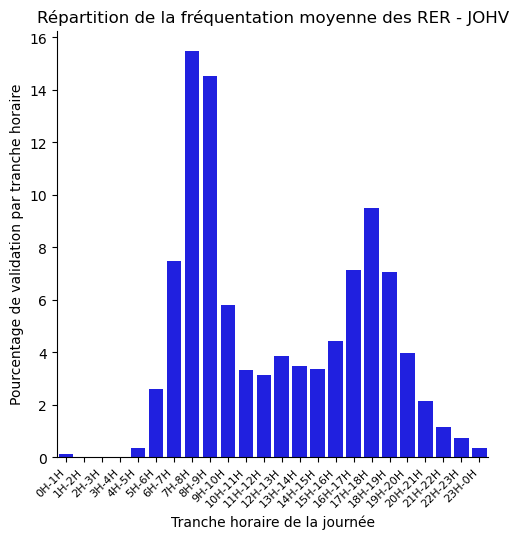

<Figure size 3000x1000 with 0 Axes>

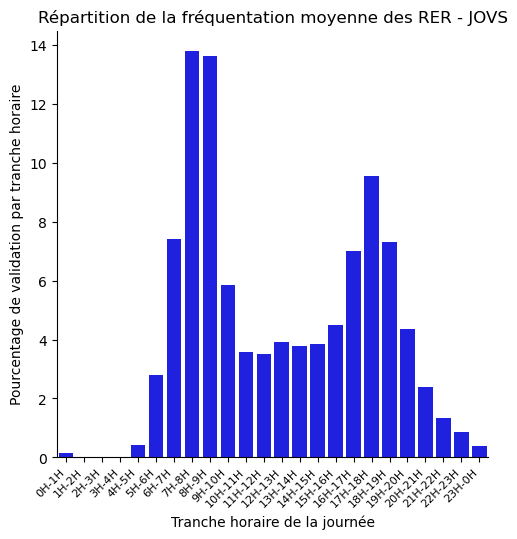

<Figure size 3000x1000 with 0 Axes>

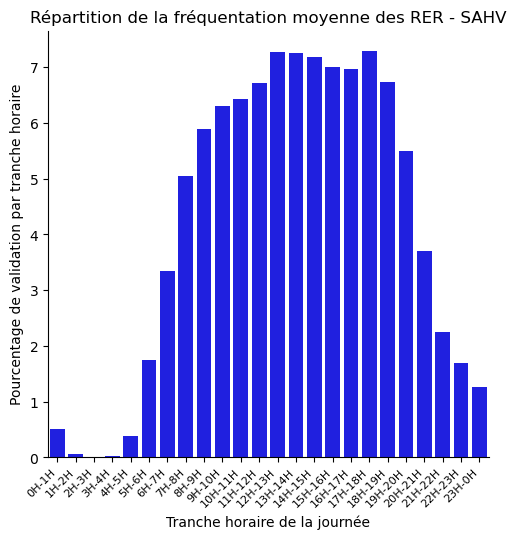

<Figure size 3000x1000 with 0 Axes>

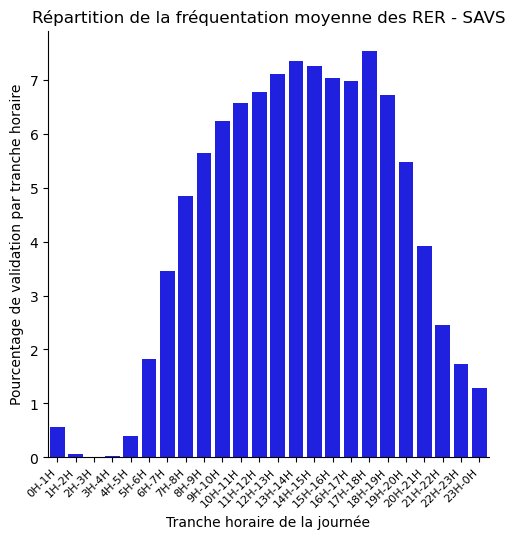

<Figure size 3000x1000 with 0 Axes>

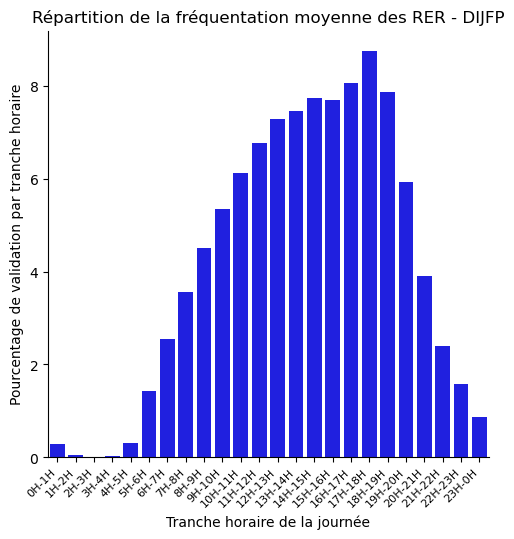

<Figure size 3000x1000 with 0 Axes>

In [83]:
jour = ['JOHV', 'JOVS', 'SAHV', 'SAVS', 'DIJFP']

# On crée une boucle qui trace 5 graphique de fréquentation horaire moyenne des RER (un graphe par catégorie de jour)
for data,cat in enumerate(jour) :
    data = profil[profil['cat_jour'] == cat]
    val_moy_jour = data.groupby(['cat_jour', 'horaire']).agg({'%_val' : 'mean'})
    repartition = sns.catplot(x='horaire', y='%_val', data=val_moy_jour, kind = "bar", height = 5, aspect = 1, color = "blue", order = heures_triees)
    ax = repartition.ax
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.figure(figsize=(30, 10))
    ax.set_xlabel('Tranche horaire de la journée')
    ax.set_ylabel('Pourcentage de validation par tranche horaire')
    ax.set_title(f"Répartition de la fréquentation moyenne des RER - {cat}")
    
plt.show()

On remarque 3 types de répartition différente : une pour les jours ouvrés, une pour les samedis, et une pour les dimanches et jours fériés ; le fait d'être en vacances ou non ne semble pas avoir d'influence sur la répartition. Est-elle la même pour tous les RER ?

In [84]:
noms_rer = ['RER A', 'RER B', 'RER C', 'RER D', 'RER E']
cat_rer ={}

# On définit les sous groupes du dataframe qui regroupent chaque ligne de RER
for rer in noms_rer:
    profil_rer = profil[profil["rer"] == rer ]
    cat_rer[rer] = profil_rer

In [85]:
jour = ['JOHV', 'JOVS', 'SAHV', 'SAVS', 'DIJFP']

def grapherer(k):
    for data,cat in enumerate(jour) :
        data = profil[profil['cat_jour'] == cat]
        val_moy_jour = data.groupby(['cat_jour', 'horaire']).agg({'%_val' : 'mean'})
        repartition = sns.catplot(x='horaire', y='%_val', data=val_moy_jour, kind = "bar", height = 5, aspect = 1, color = "blue", order = heures_triees)
        ax = repartition.ax
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.figure(figsize=(30, 10))
        ax.set_xlabel('Tranche horaire de la journée')
        ax.set_ylabel('Pourcentage de validation par tranche horaire')
        ax.set_title(f"Répartition de la fréquentation moyenne du RER - {cat} ")
    plt.show()

Notre fonction "grapherer" appelle désormais les 5 graphiques correspondants à la ligne de RER demandée

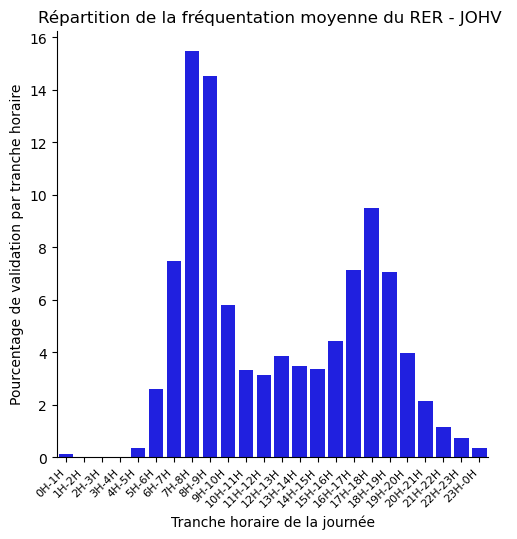

<Figure size 3000x1000 with 0 Axes>

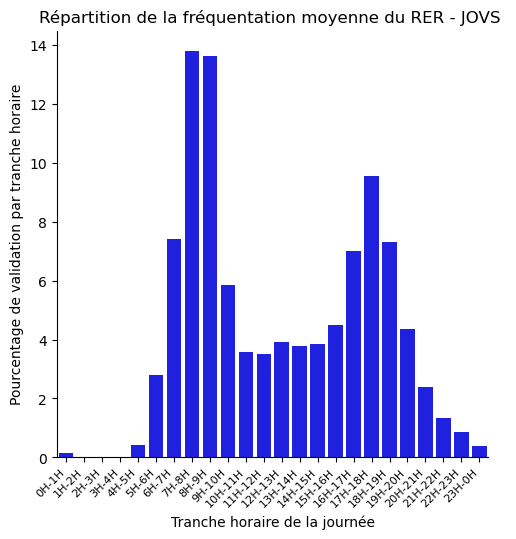

<Figure size 3000x1000 with 0 Axes>

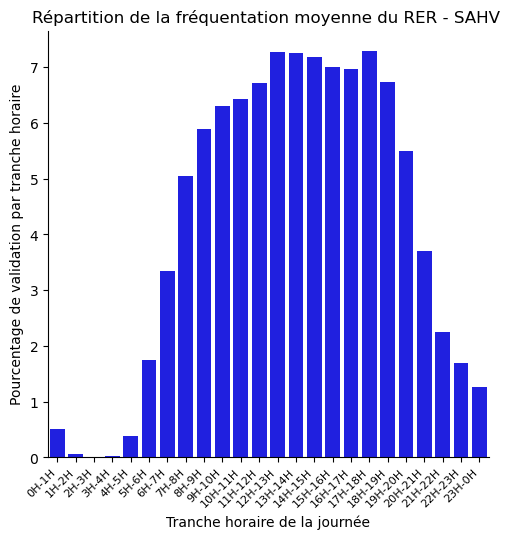

<Figure size 3000x1000 with 0 Axes>

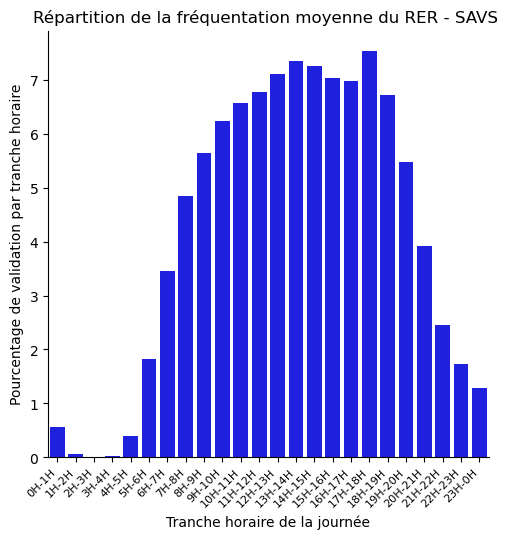

<Figure size 3000x1000 with 0 Axes>

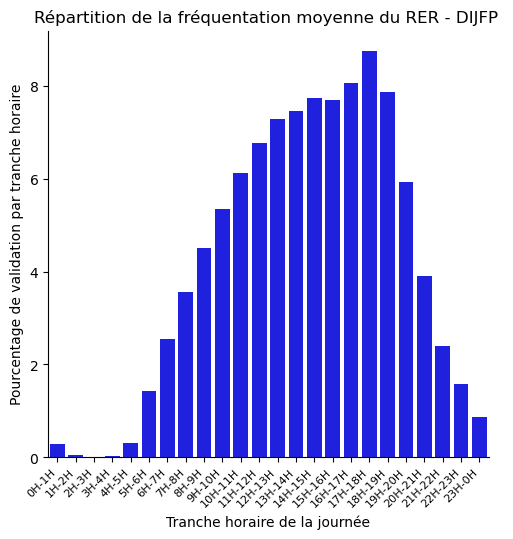

<Figure size 3000x1000 with 0 Axes>

In [86]:
grapherer(cat_rer['RER A'])